Feature Decorrelation \\
Authors: Davide Perozzi, Fabian Vincenzi


# Imports & functions

In [ ]:
!git clone https://github.com/giuluck/causalgen.git
%cd causalgen

fatal: destination path 'causalgen' already exists and is not an empty directory.
/content/causalgen/causalgen


In [ ]:
seeds = [42 * i for i in range(1, 26)]
num_data = 10000
epochs = 2

In [ ]:
import os
import random
import numpy as np
import torch
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from causalgen.generator import Generator
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
from tqdm import tqdm
from keras.models import Sequential
from sklearn.tree import DecisionTreeRegressor
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.metrics import r2_score

def set_reproducibility(seed):
  random.seed(seed)
  np.random.seed(seed)
  rng = np.random.default_rng(seed)
  torch.manual_seed(seed)
  tf.random.set_seed(1)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
# Compute the mean of the arrays and L1 and L2 norms of each array with respect to the mean array

def print_L1_L2(C_import, C_prime_import):
  mean_array = np.mean(C_import, axis=0)
  l1_norm = np.linalg.norm(C_import - mean_array, ord=1, axis=1)
  l2_norm = np.linalg.norm(C_import - mean_array, ord=2, axis=1)

  print("model C")
  print("L1 norm")
  print("mean:", np.mean(l1_norm))
  print("L2 norm")
  print("mean:", np.mean(l2_norm))
  print("\n")

  mean_array = np.mean(C_prime_import, axis=0)
  l1_norm_prime = np.linalg.norm(C_prime_import - mean_array, ord=1, axis=1)
  l2_norm_prime = np.linalg.norm(C_prime_import - mean_array, ord=2, axis=1)

  print("model C_prime")
  print("L1 norm")
  print("mean:", np.mean(l1_norm_prime))
  print("L2 norm")
  print("mean:", np.mean(l2_norm_prime))
  print("\n")

In [ ]:
def plot_coefs(results):
  plt.figure(figsize=(5, 3))

  sns.set(style="whitegrid")
  ax = sns.barplot(data=results, estimator='mean', errorbar='sd')
  ax.set_ylabel('Values')
  ax.set_xlabel('Features')

  plt.show()

# Graph #1

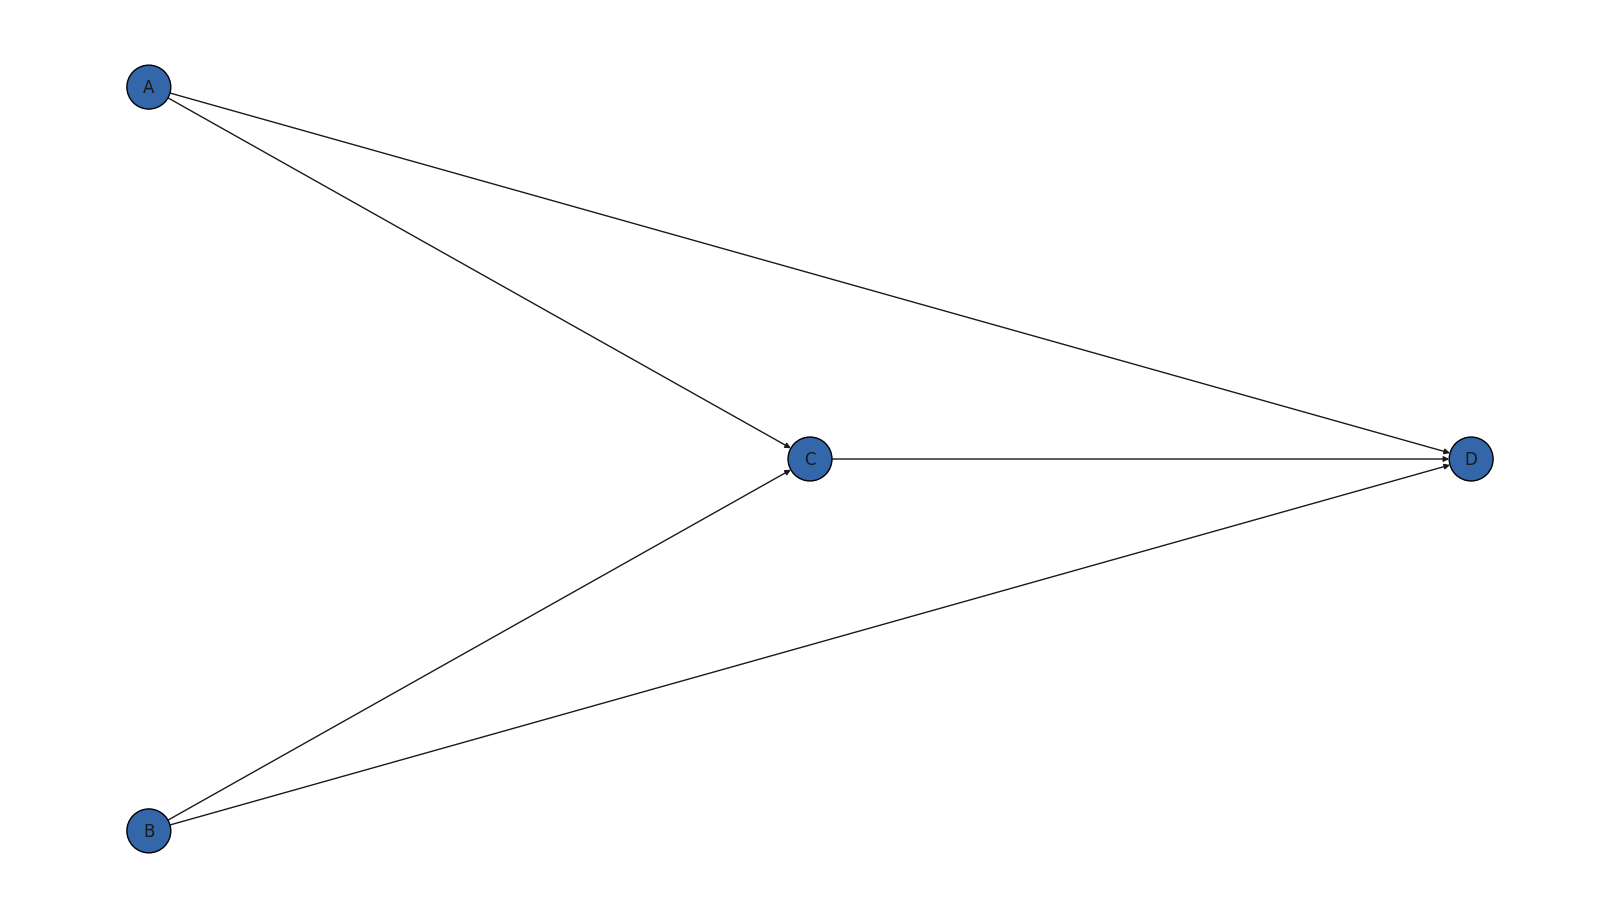

In [ ]:
seed = 42

set_reproducibility(seed)

dg = Generator(seed=seed)

A = dg.normal(mu=0, sigma=1, name='A')

B = dg.normal(mu=0, sigma=1, name='B')

C = dg.descendant(A + B, name='C')

D = dg.descendant(A + B - 3 * C, name='D')

df = dg.generate(hidden=True)
dg.visualize()

## Generate data

In [ ]:
print('\n\nGenerated Dataset')
df = pd.DataFrame(dg.generate(num=num_data))
df.head()



Generated Dataset


,A,B,C,D
0,0.750451,-1.472271,-0.721819,1.443639
1,0.940565,-0.285298,0.655267,-1.310533
2,-1.951035,0.829153,-1.121882,2.243764
3,-1.302180,0.065600,-1.236579,2.473159
4,0.127840,1.467334,1.595174,-3.190348


## Capture correlation

Capture correlation [A->C, B->C], train the model over A and B to predict C

Then compute C_prime as C-M(A,B)

In [ ]:
def build_C_prime(df):

  model = keras.Sequential([
      keras.layers.Dense(10, input_shape=[2], activation='relu'),
      keras.layers.Dense(1)
      ])

  model.compile(loss='mse', optimizer='adam')
  model.fit(df[['A','B']], df['C'],
      epochs=10,
      batch_size=32,
      verbose=False
      )

  df['C_new'] = model.predict(df[['A','B']])
  df['C_prime'] = df['C'] - df['C_new']

  return df

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

df = build_C_prime(df)

df.head()

313/313 [==============================] - 1s 2ms/step


,A,B,C,D,C_new,C_prime
0,0.750451,-1.472271,-0.721819,1.443639,-0.732003,0.010184
1,0.940565,-0.285298,0.655267,-1.310533,0.642598,0.012668
2,-1.951035,0.829153,-1.121882,2.243764,-1.118379,-0.003503
3,-1.302180,0.065600,-1.236579,2.473159,-1.215765,-0.020814
4,0.127840,1.467334,1.595174,-3.190348,1.638674,-0.043500


## Stochastic Linear Regression

### Training C

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.metrics import r2_score

C_import_nn = []
loss_history_C = []

# train the model multiple times with different seeds
for seed in seeds:
  set_reproducibility(seed)

  model_C = Sequential()
  model_C.add(Dense(1, input_dim=3, activation='linear'))

  sgd = SGD()
  model_C.compile(loss='mean_squared_error', optimizer=sgd)

  # fit the model and store the weights
  model_C.fit(df[['A','B','C']], df['D'], epochs=epochs)

  y_pred = model_C.predict(df[['A','B','C']])

  loss_history_C.append(r2_score(df['D'], y_pred))
  C_import_nn.append(model_C.layers[0].get_weights()[0].flatten())

Epoch 1/2
313/313 [==============================] - 1s 3ms/step - loss: 0.2997
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.3857
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 1ms/step - loss: 0.5695
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.5144
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.4192
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.0217
Epoch 2/2
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.2044
Epoch 2/2
313/313 [==============================]

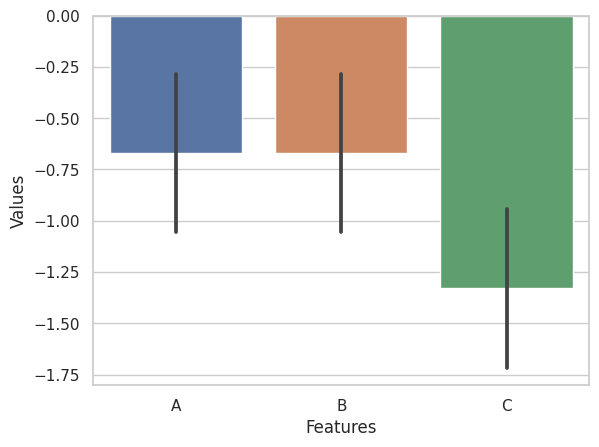

In [ ]:
results = pd.DataFrame(C_import_nn, index=seeds, columns=["A", "B","C"])
plot_coefs(results)

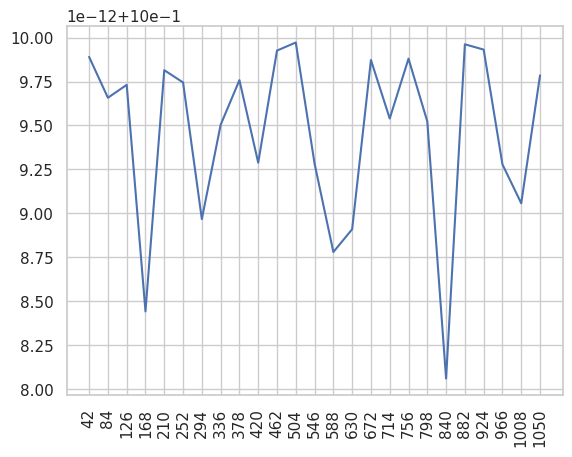

In [ ]:
seeds_ticks = range(len(seeds))
plt.plot(seeds_ticks, loss_history_C)
plt.xticks(seeds_ticks, seeds, rotation=90)
plt.show()

### Training C_prime

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.metrics import r2_score

C_prime_import_nn = []
loss_history_prime = []

# train the model multiple times with different seeds
for seed in seeds:
  set_reproducibility(seed)

  model_C_prime = Sequential()
  model_C_prime.add(Dense(1, input_dim=3, activation='linear'))

  sgd = SGD()
  model_C_prime.compile(loss='mean_squared_error', optimizer=sgd)

  # fit the model and store the weights
  model_C_prime.fit(df[['A','B','C_prime']], df['D'], epochs=epochs)

  y_pred = model_C_prime.predict(df[['A','B','C_prime']])

  loss_history_prime.append(r2_score(df['D'], y_pred))
  C_prime_import_nn.append(model_C_prime.layers[0].get_weights()[0].flatten())

Epoch 1/2
313/313 [==============================] - 1s 3ms/step - loss: 1.1355
Epoch 2/2
313/313 [==============================] - 1s 4ms/step
Epoch 1/2
313/313 [==============================] - 2s 4ms/step - loss: 0.8674
Epoch 2/2
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.7907
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.6379
Epoch 2/2
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.7147
Epoch 2/2
313/313 [==============================] - 1s 4ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.2441
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 1ms/step - loss: 0.5745
Epoch 2/2
313/313 [==============================]

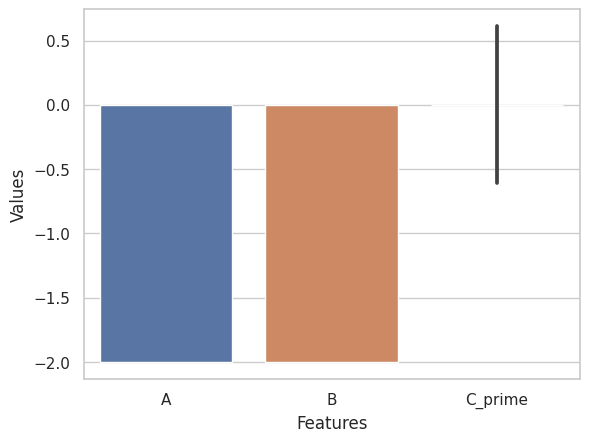

In [ ]:
results = pd.DataFrame(C_prime_import_nn, index=seeds, columns=["A", "B","C_prime"])
plot_coefs(results)

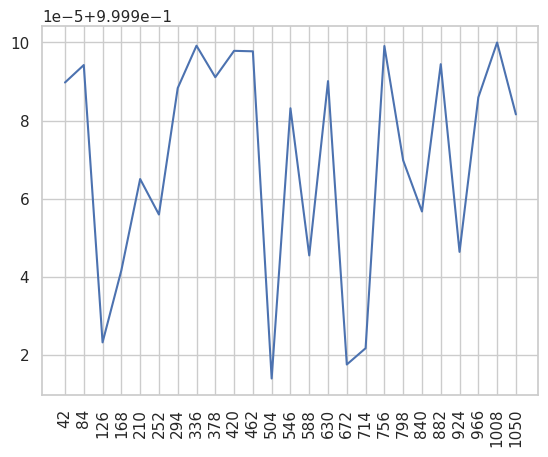

In [ ]:
seeds_ticks = range(len(seeds))
plt.plot(seeds_ticks, loss_history_prime)
plt.xticks(seeds_ticks, seeds, rotation=90)
plt.show()

### Compare trainings

In [ ]:
print_L1_L2(C_import_nn, C_prime_import_nn)

print("\n")
print("R2 C: ", np.mean(loss_history_C))
print("R2 C_prime: ", np.mean(loss_history_prime))

model C
L1 norm
mean: 1.0261371
L2 norm
mean: 0.5924406


model C_prime
L1 norm
mean: 0.513042
L2 norm
mean: 0.5122863


Ratio between models
L1_C_prime/L1_C
0.4999741


L2_C_prime/L2_C
0.8647049


R2 C:  0.9999999999994622
R2 C_prime:  0.9999699708115454


## Stochastic Decision Tree

### Train using C

In [ ]:
from sklearn.tree import DecisionTreeRegressor

C_import_tree = []
loss_history_C_tree = []

# train the model multiple times with different seeds
for seed in seeds:
  set_reproducibility(seed)

  model_C = DecisionTreeRegressor(splitter="random", random_state=seed)

  model_C.fit(df[['A','B','C']], df['D'])

  loss_history_C_tree.append(model_C.score(df[['A','B','C']], df['D']))
  C_import_tree.append(model_C.feature_importances_)

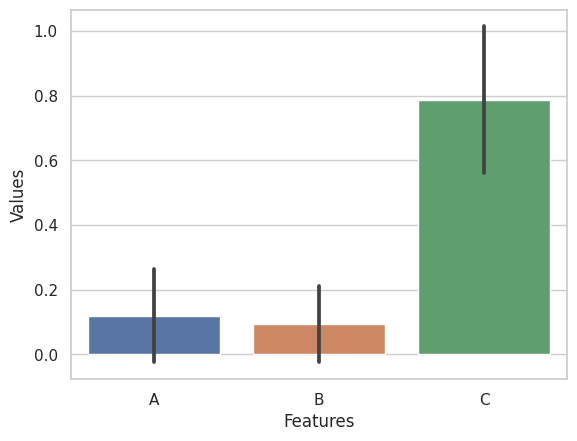

In [ ]:
results = pd.DataFrame(C_import_tree, index=seeds, columns=["A", "B","C"])
plot_coefs(results)

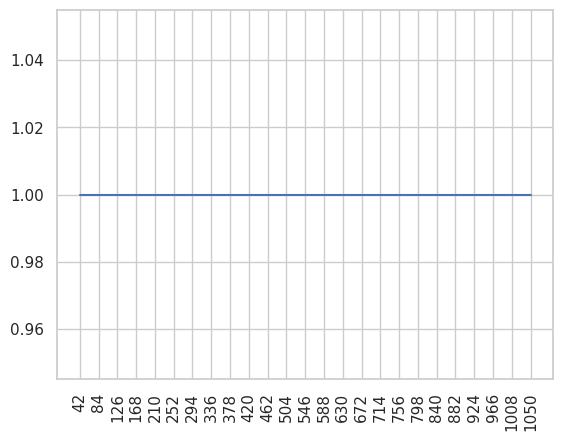

In [ ]:
seeds_ticks = range(len(seeds))
plt.plot(seeds_ticks, loss_history_C_tree)
plt.xticks(seeds_ticks, seeds, rotation=90)
plt.show()

### Train using C_prime

In [ ]:
from sklearn.tree import DecisionTreeRegressor

C_prime_import_tree = []
loss_history_prime_tree = []

# train the model multiple times with different seeds
for seed in seeds:
  set_reproducibility(seed)

  model_C_prime = DecisionTreeRegressor(splitter="random", random_state=seed)

  model_C_prime.fit(df[['A','B','C_prime']], df['D'])

  loss_history_prime_tree.append(model_C_prime.score(df[['A','B','C_prime']], df['D']))
  C_prime_import_tree.append(model_C_prime.feature_importances_)

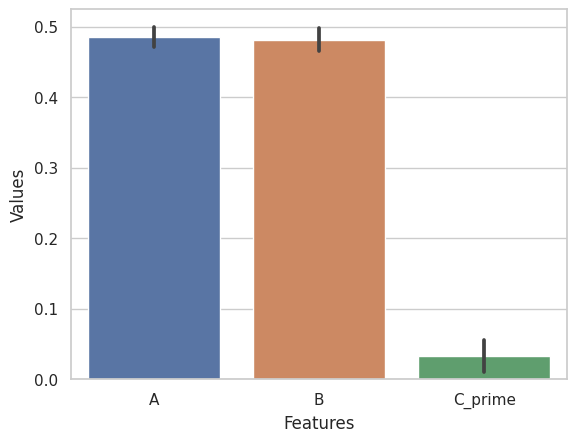

In [ ]:
results = pd.DataFrame(C_prime_import_tree, index=seeds, columns=["A", "B","C_prime"])
plot_coefs(results)

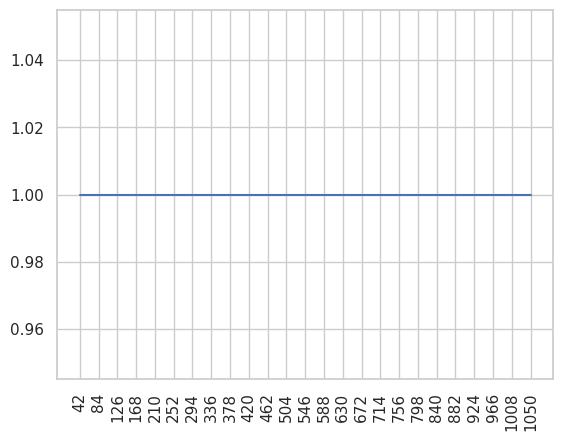

In [ ]:
seeds_ticks = range(len(seeds))
plt.plot(seeds_ticks, loss_history_prime_tree)
plt.xticks(seeds_ticks, seeds, rotation=90)
plt.show()

### Compare trainings

In [ ]:
print_L1_L2(C_import_tree, C_prime_import_tree)

print("\n")
print("R2 C: ", np.mean(loss_history_C_tree))
print("R2 C_prime: ", np.mean(loss_history_prime_tree))

model C
L1 norm
mean: 0.4022175893702846
L2 norm
mean: 0.25188163698982186


model C_prime
L1 norm
mean: 0.03862031521826921
L2 norm
mean: 0.024500457066717357


Ratio between models
L1_C_prime/L1_C
0.09601846423159542


L2_C_prime/L2_C
0.09726972303148634


R2 C:  1.0
R2 C_prime:  1.0


# Graph #2

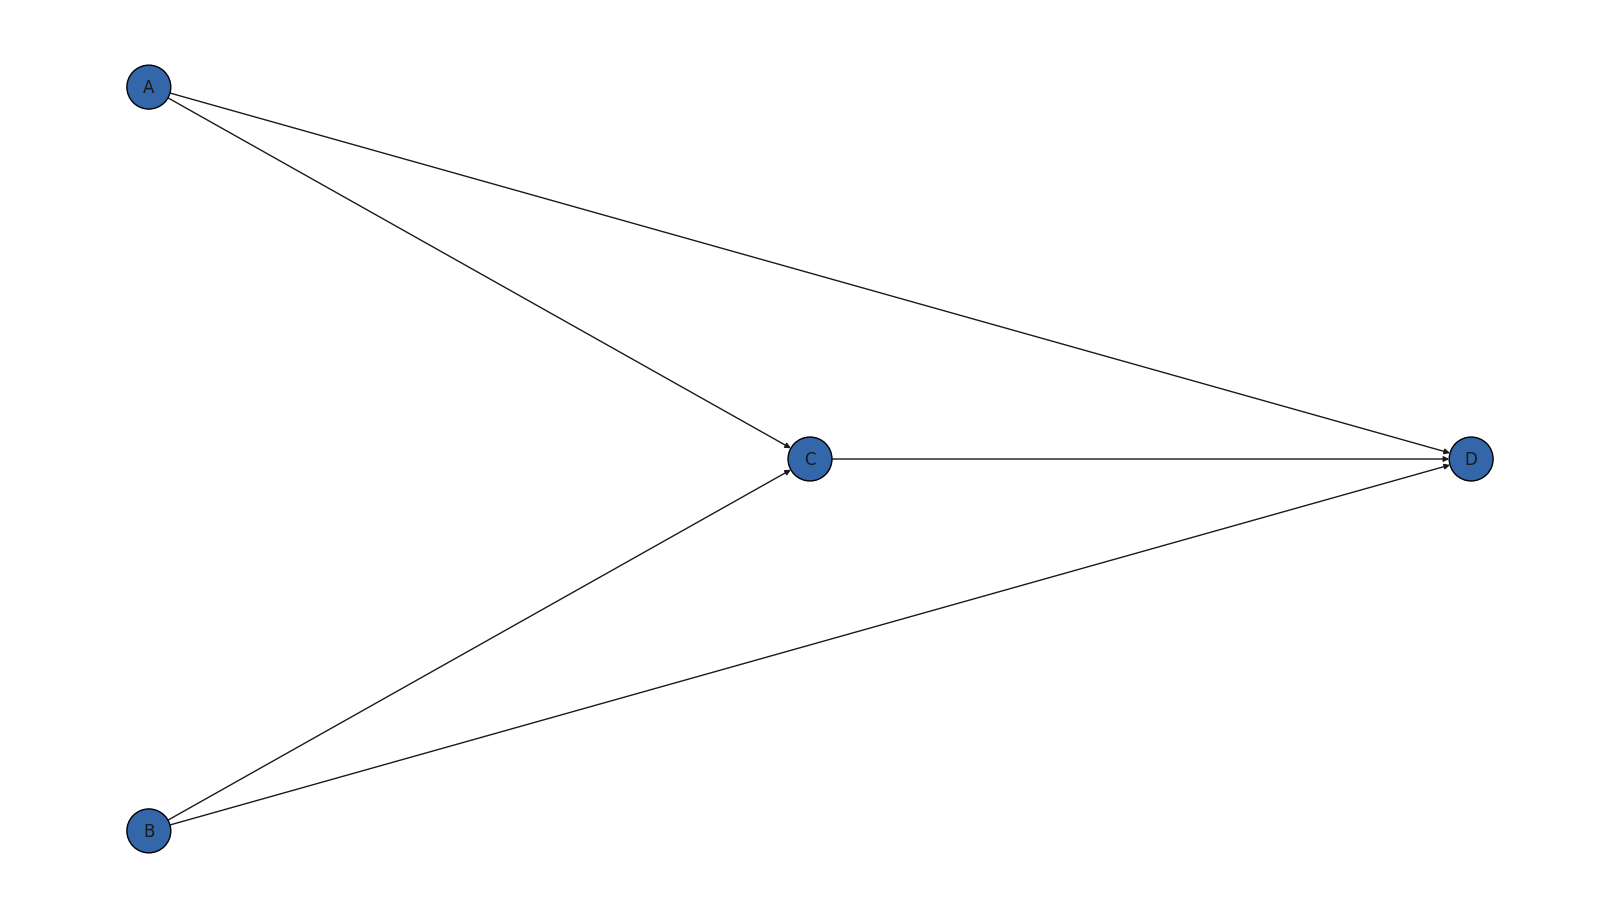

In [ ]:
seed = 42

set_reproducibility(seed)

dg = Generator(seed=seed)

A = dg.normal(mu=0.5, sigma=0.5, name='A')

B = dg.normal(mu=0.5, sigma=0.5, name='B')

C = dg.descendant(A + B, name='C')

D = dg.descendant(A + B - 3 * C, name='D')

df = dg.generate(hidden=True)
dg.visualize()

## Generate data

In [ ]:
print('\n\nGenerated Dataset')
df = pd.DataFrame(dg.generate(num=num_data))
df.head()



Generated Dataset


,A,B,C,D
0,0.875226,-0.236135,0.639090,-1.278181
1,0.970282,0.357351,1.327633,-2.655267
2,-0.475518,0.914577,0.439059,-0.878118
3,-0.151090,0.532800,0.381710,-0.763421
4,0.563920,1.233667,1.797587,-3.595174


## Capture correlation

Capture correlation [A->C, B->C], train the model over A and B to predict C

Then compute C_prime as C-M(A,B)

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def build_C_prime(df):

  model = keras.Sequential([
      keras.layers.Dense(10, input_shape=[2], activation='relu'),
      keras.layers.Dense(1)
      ])

  model.compile(loss='mse', optimizer='adam')
  model.fit(df[['A','B']], df['C'],
      epochs=10,
      batch_size=32,
      verbose=False
      )

  df['C_new'] = model.predict(df[['A','B']])
  df['C_prime'] = df['C'] - df['C_new']

  return df

In [ ]:
df = build_C_prime(df)

df.head()

313/313 [==============================] - 0s 1ms/step


,A,B,C,D,C_new,C_prime
0,0.875226,-0.236135,0.639090,-1.278181,0.623719,0.015371
1,0.970282,0.357351,1.327633,-2.655267,1.319602,0.008031
2,-0.475518,0.914577,0.439059,-0.878118,0.367369,0.071690
3,-0.151090,0.532800,0.381710,-0.763421,0.409261,-0.027551
4,0.563920,1.233667,1.797587,-3.595174,1.779183,0.018404


## Stochastic Linear Regression

### Training C

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.metrics import r2_score

C_import_nn = []
loss_history_C = []

# train the model multiple times with different seeds
for seed in seeds:
  set_reproducibility(seed)

  model_C = Sequential()
  model_C.add(Dense(1, input_dim=3, activation='linear'))

  sgd = SGD()
  model_C.compile(loss='mean_squared_error', optimizer=sgd)

  # fit the model and store the weights
  model_C.fit(df[['A','B','C']], df['D'], epochs=epochs)

  y_pred = model_C.predict(df[['A','B','C']])

  loss_history_C.append(r2_score(df['D'], y_pred))
  C_import_nn.append(model_C.layers[0].get_weights()[0].flatten())

Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.2929
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 1ms/step - loss: 0.3764
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.5564
Epoch 2/2
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.4990
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.4100
Epoch 2/2
313/313 [==============================] - 1s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.0210
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.1970
Epoch 2/2
313/313 [==============================]

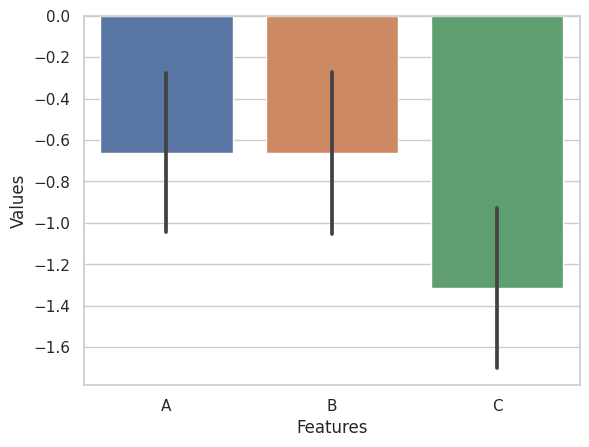

In [ ]:
results = pd.DataFrame(C_import_nn, index=seeds, columns=["A", "B","C"])

plot_coefs(results)

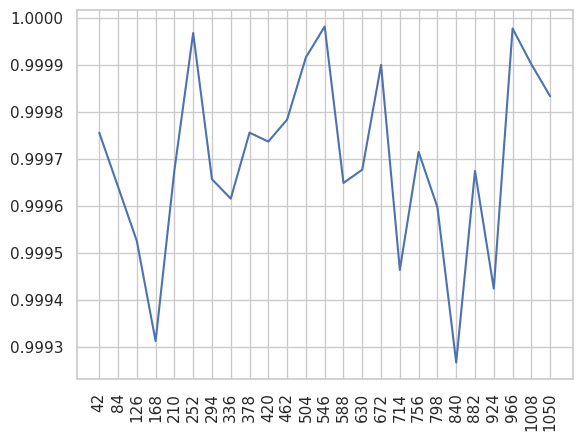

In [ ]:
seeds_ticks = range(len(seeds))
plt.plot(seeds_ticks, loss_history_C)
plt.xticks(seeds_ticks, seeds, rotation=90)
plt.show()

### Training C_prime

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.metrics import r2_score

C_prime_import_nn = []
loss_history_prime = []

# train the model multiple times with different seeds
for seed in seeds:
  set_reproducibility(seed)

  model_C_prime = Sequential()
  model_C_prime.add(Dense(1, input_dim=3, activation='linear'))

  sgd = SGD()
  model_C_prime.compile(loss='mean_squared_error', optimizer=sgd)

  # fit the model and store the weights
  model_C_prime.fit(df[['A','B','C_prime']], df['D'], epochs=epochs)

  y_pred = model_C_prime.predict(df[['A','B','C_prime']])

  loss_history_prime.append(r2_score(df['D'], y_pred))
  C_prime_import_nn.append(model_C_prime.layers[0].get_weights()[0].flatten())

Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 1.0406
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.7953
Epoch 2/2
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
313/313 [==============================] - 1s 3ms/step - loss: 0.7266
Epoch 2/2
313/313 [==============================] - 2s 6ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.5898
Epoch 2/2
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.6551
Epoch 2/2
313/313 [==============================] - 1s 4ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.2247
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.5303
Epoch 2/2
313/313 [==============================]

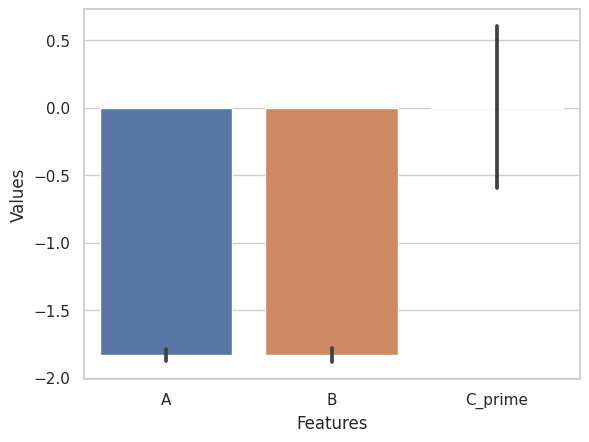

In [ ]:
results = pd.DataFrame(C_prime_import_nn, index=seeds, columns=["A", "B","C_prime"])
plot_coefs(results)

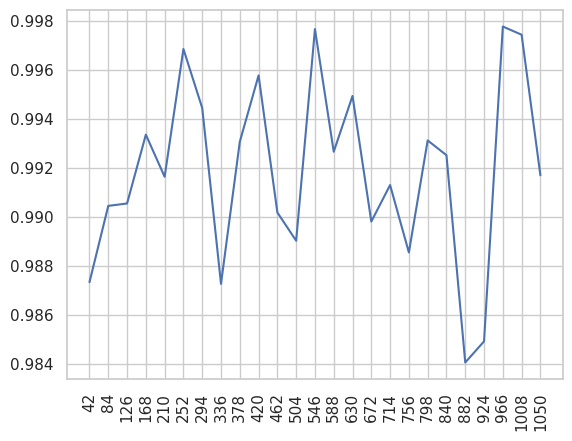

In [ ]:
seeds_ticks = range(len(seeds))
plt.plot(seeds_ticks, loss_history_prime)
plt.xticks(seeds_ticks, seeds, rotation=90)
plt.show()

### Compare trainings

In [ ]:
print_L1_L2(C_import_nn, C_prime_import_nn)

print("\n")
print("R2 C: ", np.mean(loss_history_C))
print("R2 C_prime: ", np.mean(loss_history_prime))

model C
L1 norm
mean: 1.0261371
L2 norm
mean: 0.5935654


model C_prime
L1 norm
mean: 0.58344287
L2 norm
mean: 0.5132394


Ratio between models
L1_C_prime/L1_C
0.56858176


L2_C_prime/L2_C
0.864672


R2 C:  0.9996960511480956
R2 C_prime:  0.9918590639223619


## Stochastic Decision Tree

### Train using C

In [ ]:
from sklearn.tree import DecisionTreeRegressor

C_import_tree = []
loss_history_C_tree = []

# train the model multiple times with different seeds
for seed in seeds:
  set_reproducibility(seed)

  model_C = DecisionTreeRegressor(splitter="random", random_state=seed)

  model_C.fit(df[['A','B','C']], df['D'])

  loss_history_C_tree.append(model_C.score(df[['A','B','C']], df['D']))
  C_import_tree.append(model_C.feature_importances_)

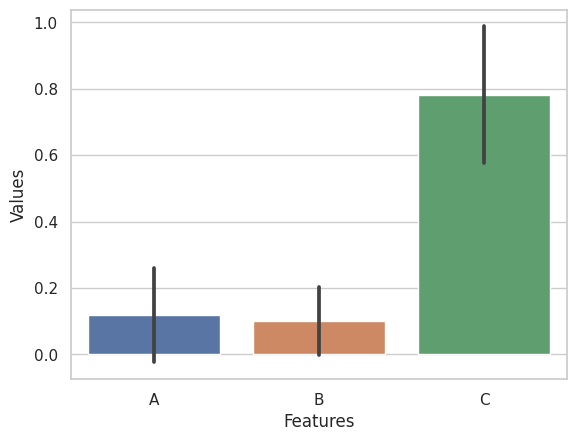

In [ ]:
results = pd.DataFrame(C_import_tree, index=seeds, columns=["A", "B","C"])
plot_coefs(results)

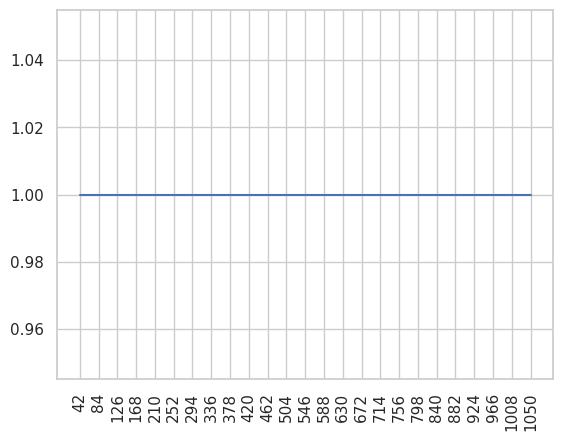

In [ ]:
seeds_ticks = range(len(seeds))
plt.plot(seeds_ticks, loss_history_C_tree)
plt.xticks(seeds_ticks, seeds, rotation=90)
plt.show()

### Train using C_prime

In [ ]:
from sklearn.tree import DecisionTreeRegressor

C_prime_import_tree = []
loss_history_prime_tree = []

# train the model multiple times with different seeds
for seed in seeds:
  set_reproducibility(seed)

  model_C_prime = DecisionTreeRegressor(splitter="random", random_state=seed)

  model_C_prime.fit(df[['A','B','C_prime']], df['D'])

  loss_history_prime_tree.append(model_C_prime.score(df[['A','B','C_prime']], df['D']))
  C_prime_import_tree.append(model_C_prime.feature_importances_)

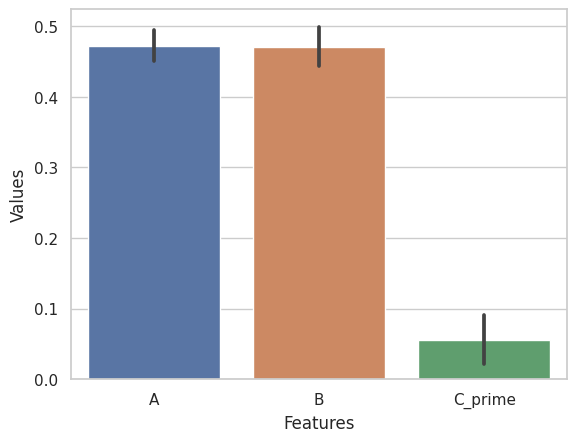

In [ ]:
results = pd.DataFrame(C_prime_import_tree, index=seeds, columns=["A", "B","C_prime"])
plot_coefs(results)

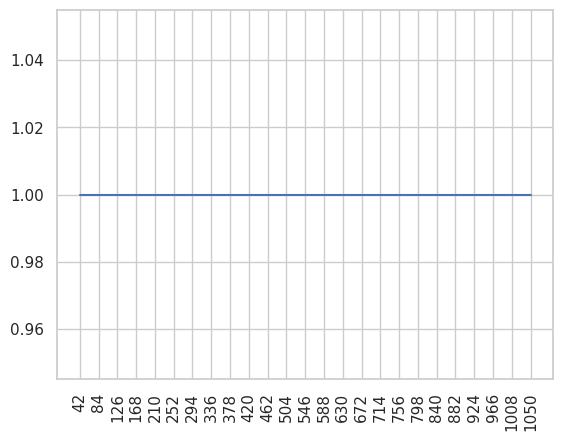

In [ ]:
seeds_ticks = range(len(seeds))
plt.plot(seeds_ticks, loss_history_prime_tree)
plt.xticks(seeds_ticks, seeds, rotation=90)
plt.show()

### Compare trainings

In [ ]:
print_L1_L2(C_import_tree, C_prime_import_tree)

print("\n")
print("R2 C: ", np.mean(loss_history_C_tree))
print("R2 C_prime: ", np.mean(loss_history_prime_tree))

model C
L1 norm
mean: 0.37525219512454666
L2 norm
mean: 0.2398708913849217


model C_prime
L1 norm
mean: 0.06531988472062891
L2 norm
mean: 0.04099763077211826


Ratio between models
L1_C_prime/L1_C
0.1740692941155192


L2_C_prime/L2_C
0.17091540593113988


R2 C:  1.0
R2 C_prime:  1.0


# Graph #3

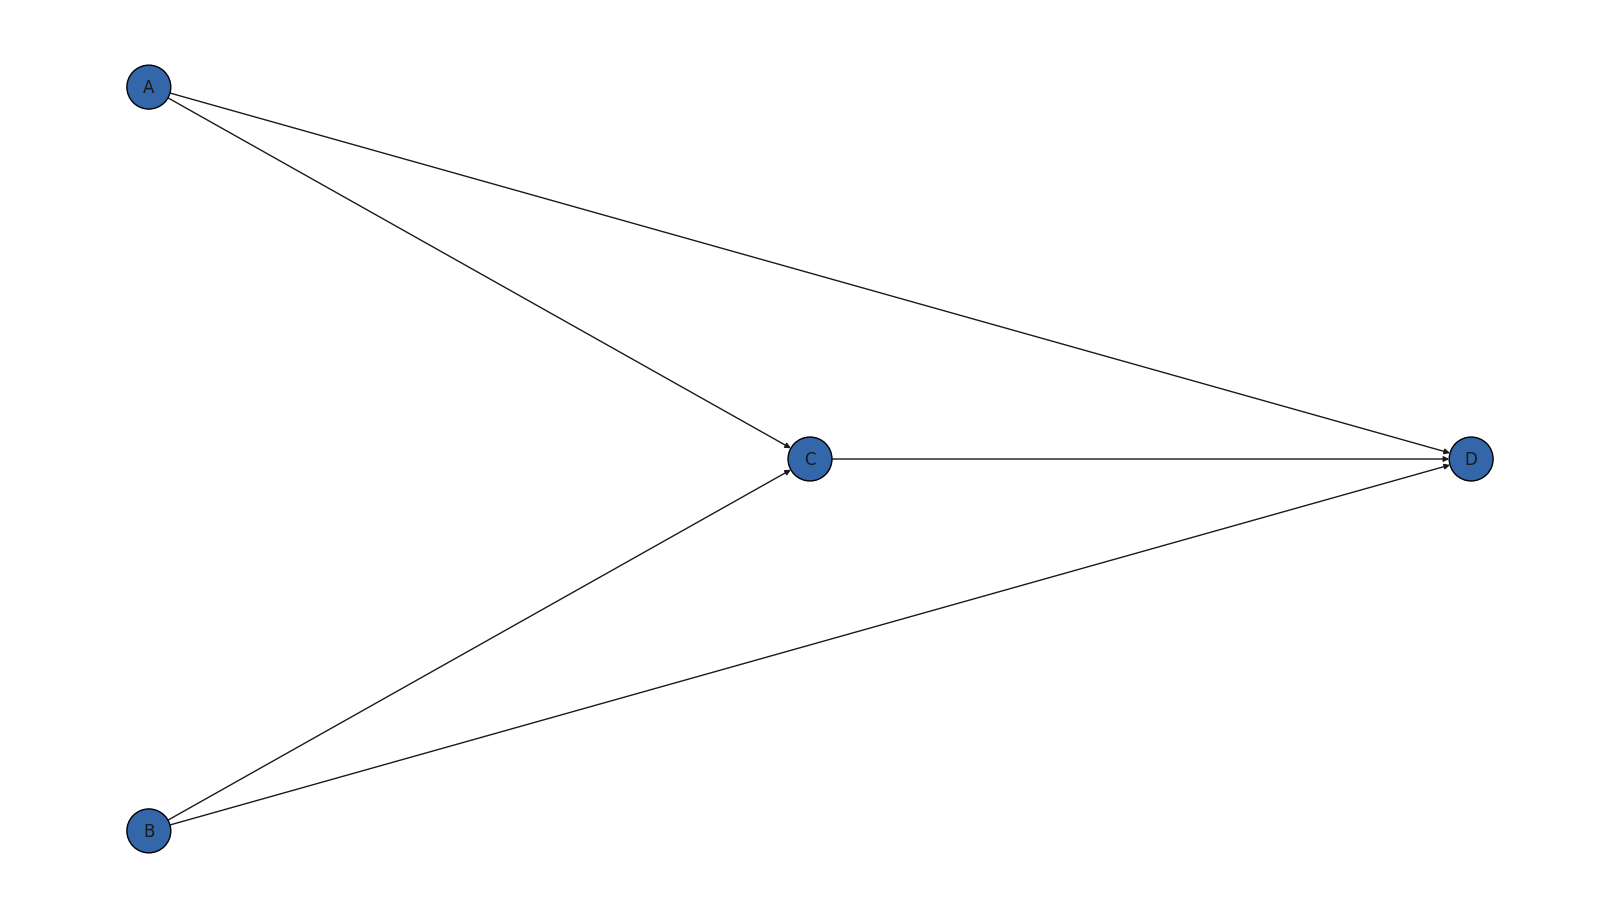

In [ ]:
seed = 42
set_reproducibility(seed)

dg = Generator(seed=seed)

A = dg.normal(mu=1.0, sigma=0.2, name='A')
B = dg.normal(mu=0.8, sigma=0.4, name='B')

C = dg.descendant(A + B, name='C')
D = dg.descendant(A + B - 3 * C, name='D')

df = dg.generate(hidden=True)
dg.visualize()


## Generate data

In [ ]:
print('\n\nGenerated Dataset')
df = pd.DataFrame(dg.generate(num=num_data))
df.head()



Generated Dataset


,A,B,C,D
0,1.150090,0.211092,1.361182,-2.722364
1,1.188113,0.685881,1.873994,-3.747987
2,0.609793,1.131661,1.741454,-3.482909
3,0.739564,0.826240,1.565804,-3.131608
4,1.025568,1.386934,2.412502,-4.825003


## Capture correlation

Capture correlation [A->C, B->C], train the model over A and B to predict C

Then compute C_prime as C-M(A,B)

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def build_C_prime(df):

  model = keras.Sequential([
      keras.layers.Dense(10, input_shape=[2], activation='relu'),
      keras.layers.Dense(1)
      ])

  model.compile(loss='mse', optimizer='adam')
  model.fit(df[['A','B']], df['C'],
      epochs=10,
      batch_size=32,
      verbose=False
      )

  df['C_new'] = model.predict(df[['A','B']])
  df['C_prime'] = df['C'] - df['C_new']

  return df

In [ ]:
df = build_C_prime(df)

df.head()

313/313 [==============================] - 1s 1ms/step


,A,B,C,D,C_new,C_prime
0,1.150090,0.211092,1.361182,-2.722364,1.356280,0.004902
1,1.188113,0.685881,1.873994,-3.747987,1.876410,-0.002416
2,0.609793,1.131661,1.741454,-3.482909,1.743323,-0.001869
3,0.739564,0.826240,1.565804,-3.131608,1.569345,-0.003541
4,1.025568,1.386934,2.412502,-4.825003,2.410423,0.002079


## Stochastic Linear Regression

### Training C

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.metrics import r2_score

C_import_nn = []
loss_history_C = []

# train the model multiple times with different seeds
for seed in seeds:
  set_reproducibility(seed)

  model_C = Sequential()
  model_C.add(Dense(1, input_dim=3, activation='linear'))

  sgd = SGD()
  model_C.compile(loss='mean_squared_error', optimizer=sgd)

  # fit the model and store the weights
  model_C.fit(df[['A','B','C']], df['D'], epochs=epochs)

  y_pred = model_C.predict(df[['A','B','C']])

  loss_history_C.append(r2_score(df['D'], y_pred))
  C_import_nn.append(model_C.layers[0].get_weights()[0].flatten())

Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.2688
Epoch 2/2
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.3689
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.5065
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.4811
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.3890
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 1ms/step - loss: 0.0163
Epoch 2/2
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.1477
Epoch 2/2
313/313 [==============================]

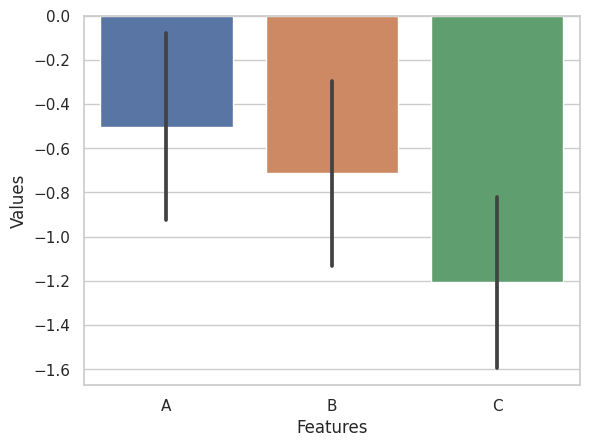

In [ ]:
results = pd.DataFrame(C_import_nn, index=seeds, columns=["A", "B","C"])
plot_coefs(results)

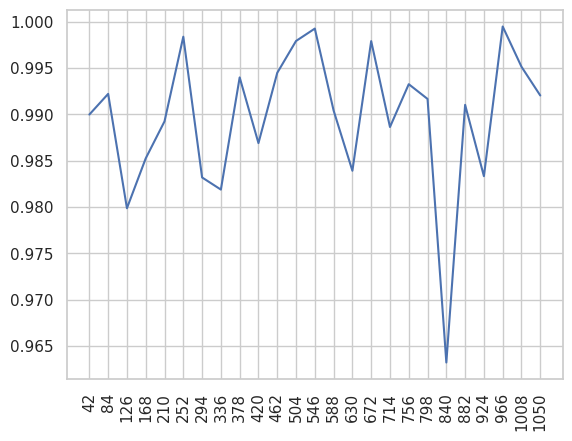

In [ ]:
seeds_ticks = range(len(seeds))
plt.plot(seeds_ticks, loss_history_C)
plt.xticks(seeds_ticks, seeds, rotation=90)
plt.show()

### Training C_prime

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.metrics import r2_score

C_prime_import_nn = []
loss_history_prime = []

# train the model multiple times with different seeds
for seed in seeds:
  set_reproducibility(seed)

  model_C_prime = Sequential()
  model_C_prime.add(Dense(1, input_dim=3, activation='linear'))

  sgd = SGD()
  model_C_prime.compile(loss='mean_squared_error', optimizer=sgd)

  # fit the model and store the weights
  model_C_prime.fit(df[['A','B','C_prime']], df['D'], epochs=epochs)

  y_pred = model_C_prime.predict(df[['A','B','C_prime']])

  loss_history_prime.append(r2_score(df['D'], y_pred))
  C_prime_import_nn.append(model_C_prime.layers[0].get_weights()[0].flatten())

Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.8537
Epoch 2/2
313/313 [==============================] - 1s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.7030
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.5771
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.5423
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.5485
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.1775
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 0.3845
Epoch 2/2
313/313 [==============================]

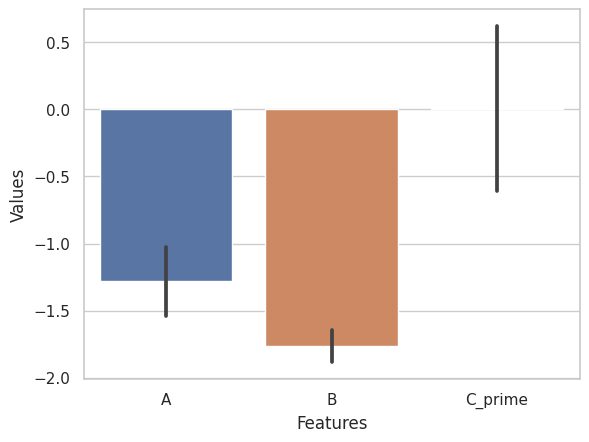

In [ ]:
results = pd.DataFrame(C_prime_import_nn, index=seeds, columns=["A", "B","C_prime"])
plot_coefs(results)

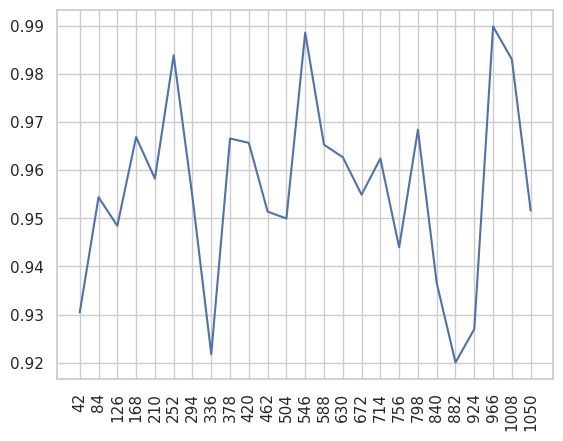

In [ ]:
seeds_ticks = range(len(seeds))
plt.plot(seeds_ticks, loss_history_prime)
plt.xticks(seeds_ticks, seeds, rotation=90)
plt.show()

### Compare trainings

In [ ]:
print_L1_L2(C_import_nn, C_prime_import_nn)

print("\n")
print("R2 C: ", np.mean(loss_history_C))
print("R2 C_prime: ", np.mean(loss_history_prime))

model C
L1 norm
mean: 1.0651654
L2 norm
mean: 0.6439315


model C_prime
L1 norm
mean: 0.8363545
L2 norm
mean: 0.6000942


Ratio between models
L1_C_prime/L1_C
0.7851874


L2_C_prime/L2_C
0.9319224


R2 C:  0.9897103231966955
R2 C_prime:  0.9562363327078297


## Stochastic Decision Tree

### Train using C

In [ ]:
from sklearn.tree import DecisionTreeRegressor

C_import_tree = []
loss_history_C_tree = []

# train the model multiple times with different seeds
for seed in seeds:
  set_reproducibility(seed)

  model_C = DecisionTreeRegressor(splitter="random", random_state=seed)

  model_C.fit(df[['A','B','C']], df['D'])

  loss_history_C_tree.append(model_C.score(df[['A','B','C']], df['D']))
  C_import_tree.append(model_C.feature_importances_)

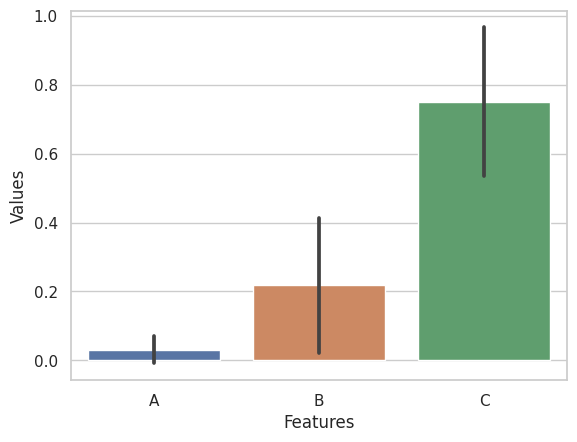

In [ ]:
results = pd.DataFrame(C_import_tree, index=seeds, columns=["A", "B","C"])
plot_coefs(results)

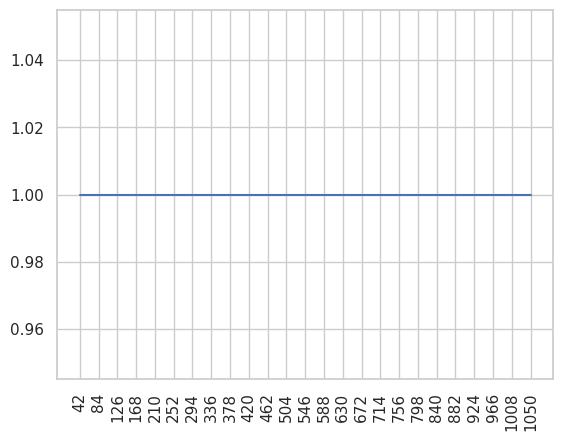

In [ ]:
seeds_ticks = range(len(seeds))
plt.plot(seeds_ticks, loss_history_C_tree)
plt.xticks(seeds_ticks, seeds, rotation=90)
plt.show()

### Train using C_prime

In [ ]:
from sklearn.tree import DecisionTreeRegressor

C_prime_import_tree = []
loss_history_prime_tree = []

# train the model multiple times with different seeds
for seed in seeds:
  set_reproducibility(seed)

  model_C_prime = DecisionTreeRegressor(splitter="random", random_state=seed)

  model_C_prime.fit(df[['A','B','C_prime']], df['D'])

  loss_history_prime_tree.append(model_C_prime.score(df[['A','B','C_prime']], df['D']))
  C_prime_import_tree.append(model_C_prime.feature_importances_)

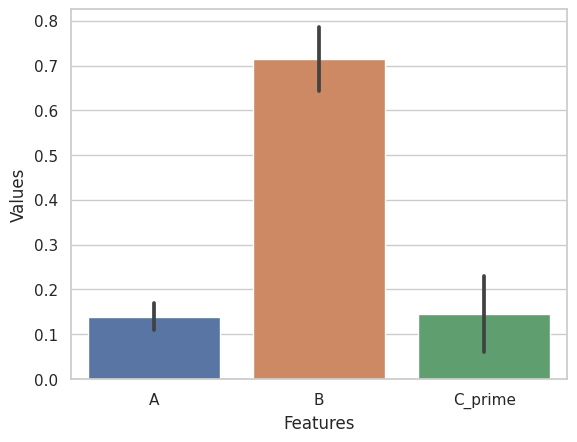

In [ ]:
results = pd.DataFrame(C_prime_import_tree, index=seeds, columns=["A", "B","C_prime"])
plot_coefs(results)

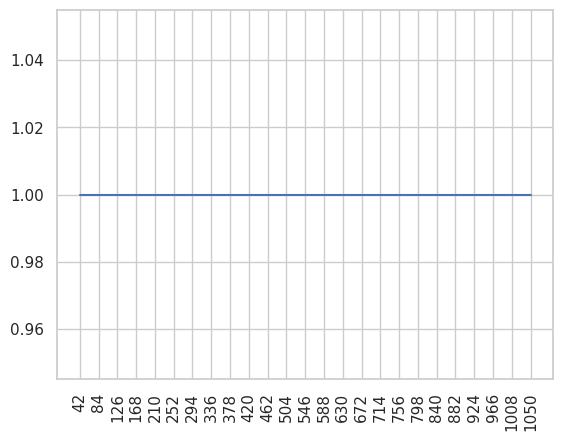

In [ ]:
seeds_ticks = range(len(seeds))
plt.plot(seeds_ticks, loss_history_prime_tree)
plt.xticks(seeds_ticks, seeds, rotation=90)
plt.show()

### Compare trainings

In [ ]:
print_L1_L2(C_import_tree, C_prime_import_tree)

print("\n")
print("R2 C: ", np.mean(loss_history_C_tree))
print("R2 C_prime: ", np.mean(loss_history_prime_tree))

model C
L1 norm
mean: 0.37856486214348634
L2 norm
mean: 0.25273678786149467


model C_prime
L1 norm
mean: 0.13456206489739553
L2 norm
mean: 0.08581270988385083


Ratio between models
L1_C_prime/L1_C
0.35545312931444983


L2_C_prime/L2_C
0.33953391039723935


R2 C:  1.0
R2 C_prime:  1.0


# Graph with noise

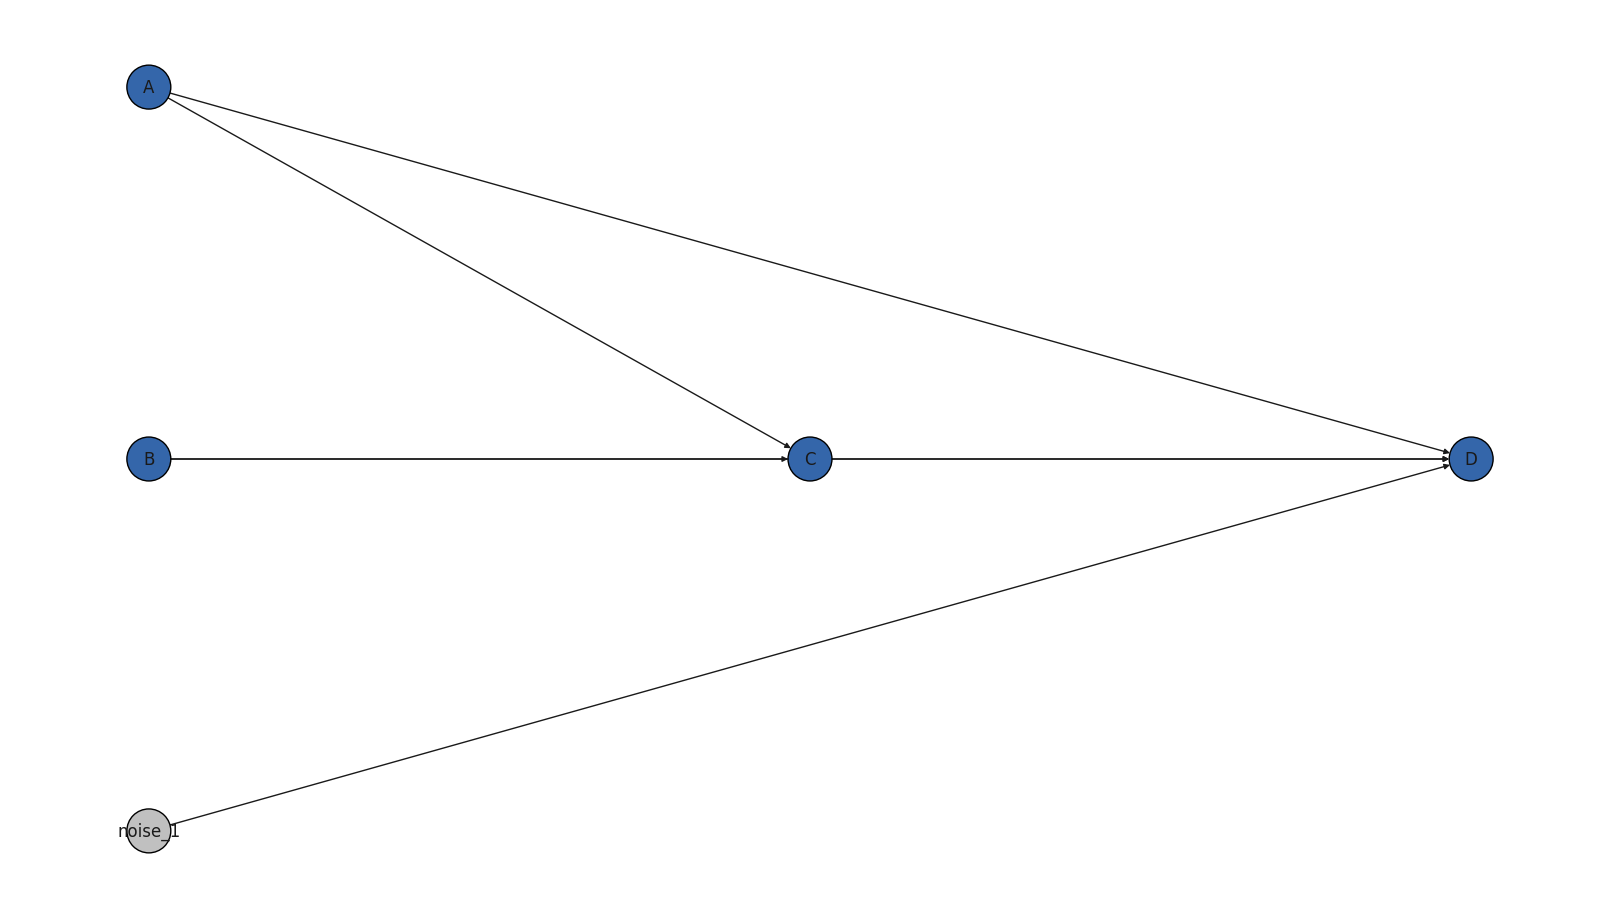

In [ ]:
seed = 42

set_reproducibility(seed)

dg = Generator(seed=seed)

A = dg.normal(mu=0, sigma=1, name='A')

B = dg.normal(mu=0, sigma=1, name='B')

C = dg.descendant(A + B, name='C')

D = dg.descendant(A + B - 3 * C + dg.noise(), name='D')

df = dg.generate(hidden=True)
dg.visualize()

## Generate data

In [ ]:
print('\n\nGenerated Dataset')
df = pd.DataFrame(dg.generate(num=num_data))
df.head()



Generated Dataset


,A,B,C,D
0,0.940565,-0.285298,0.655267,-1.910442
1,-1.951035,0.829153,-1.121882,1.992946
2,-1.302180,0.065600,-1.236579,3.509930
3,0.127840,1.467334,1.595174,-2.459108
4,-0.316243,-1.575923,-1.892166,3.656408


## Capture correlation

Capture correlation [A->C, B->C], train the model over A and B to predict C

Then compute C_prime as C-M(A,B)

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def build_C_prime(df):

  model = keras.Sequential([
      keras.layers.Dense(10, input_shape=[2], activation='relu'),
      keras.layers.Dense(1)
      ])

  model.compile(loss='mse', optimizer='adam')
  model.fit(df[['A','B']], df['C'],
      epochs=10,
      batch_size=32,
      verbose=False
      )

  df['C_new'] = model.predict(df[['A','B']])
  df['C_prime'] = df['C'] - df['C_new']

  return df

In [ ]:
df = build_C_prime(df)

df.head()

313/313 [==============================] - 1s 2ms/step


,A,B,C,D,C_new,C_prime
0,0.940565,-0.285298,0.655267,-1.910442,0.644340,0.010926
1,-1.951035,0.829153,-1.121882,1.992946,-1.127304,0.005422
2,-1.302180,0.065600,-1.236579,3.509930,-1.206865,-0.029715
3,0.127840,1.467334,1.595174,-2.459108,1.644656,-0.049482
4,-0.316243,-1.575923,-1.892166,3.656408,-1.909662,0.017496


## Stochastic Linear Regression

### Training C

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.metrics import r2_score

C_import_nn = []
loss_history_C = []

# train the model multiple times with different seeds
for seed in seeds:
  set_reproducibility(seed)

  model_C = Sequential()
  model_C.add(Dense(1, input_dim=3, activation='linear'))

  sgd = SGD()
  model_C.compile(loss='mean_squared_error', optimizer=sgd)

  # fit the model and store the weights
  model_C.fit(df[['A','B','C']], df['D'], epochs=epochs)
  y_pred = model_C.predict(df[['A','B','C']])

  loss_history_C.append(r2_score(df['D'], y_pred))
  C_import_nn.append(model_C.layers[0].get_weights()[0].flatten())

Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 1.3087
Epoch 2/2
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
313/313 [==============================] - 4s 9ms/step - loss: 1.3923
Epoch 2/2
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 1.5789
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 1.5191
Epoch 2/2
313/313 [==============================] - 1s 3ms/step
Epoch 1/2
313/313 [==============================] - 2s 3ms/step - loss: 1.4274
Epoch 2/2
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 1.0305
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 1ms/step - loss: 1.2153
Epoch 2/2
313/313 [==============================]

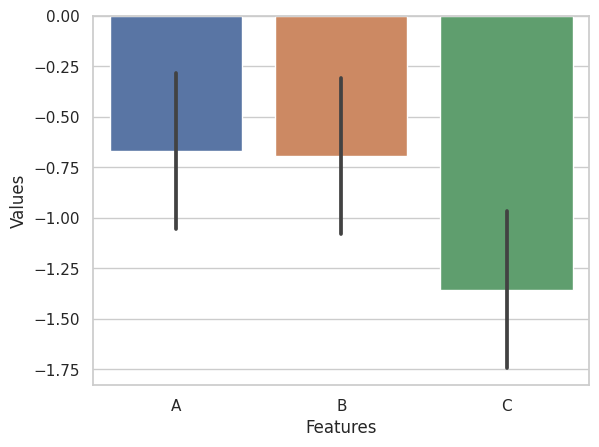

In [ ]:
results = pd.DataFrame(C_import_nn, index=seeds, columns=["A", "B","C"])
plot_coefs(results)

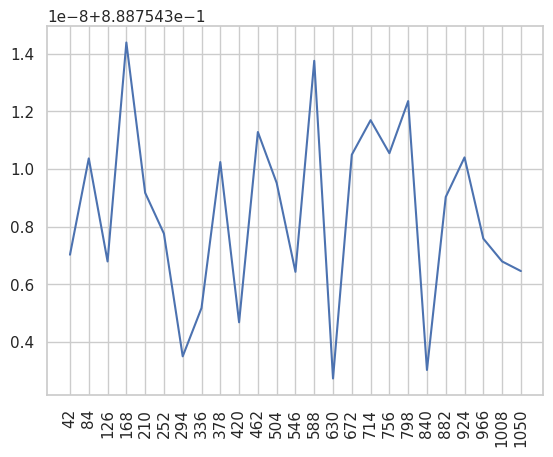

In [ ]:
seeds_ticks = range(len(seeds))
plt.plot(seeds_ticks, loss_history_C)
plt.xticks(seeds_ticks, seeds, rotation=90)
plt.show()

### Training C_prime

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.metrics import r2_score

C_prime_import_nn = []
loss_history_prime = []

# train the model multiple times with different seeds
for seed in seeds:
  set_reproducibility(seed)

  model_C_prime = Sequential()
  model_C_prime.add(Dense(1, input_dim=3, activation='linear'))

  sgd = SGD()
  model_C_prime.compile(loss='mean_squared_error', optimizer=sgd)

  # fit the model and store the weights
  model_C_prime.fit(df[['A','B','C_prime']], df['D'], epochs=epochs)

  y_pred = model_C_prime.predict(df[['A','B','C_prime']])

  loss_history_prime.append(r2_score(df['D'], y_pred))
  C_prime_import_nn.append(model_C_prime.layers[0].get_weights()[0].flatten())

Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 2.1512
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 1.8798
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 1.8052
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 1.6474
Epoch 2/2
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 1.7280
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 1.2556
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 1ms/step - loss: 1.5895
Epoch 2/2
313/313 [==============================]

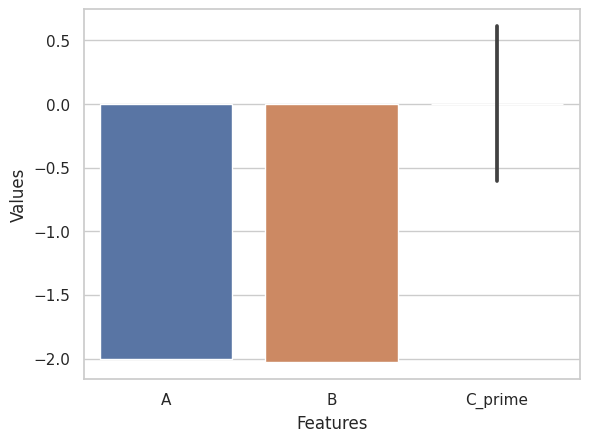

In [ ]:
results = pd.DataFrame(C_prime_import_nn, index=seeds, columns=["A", "B","C_prime"])
plot_coefs(results)

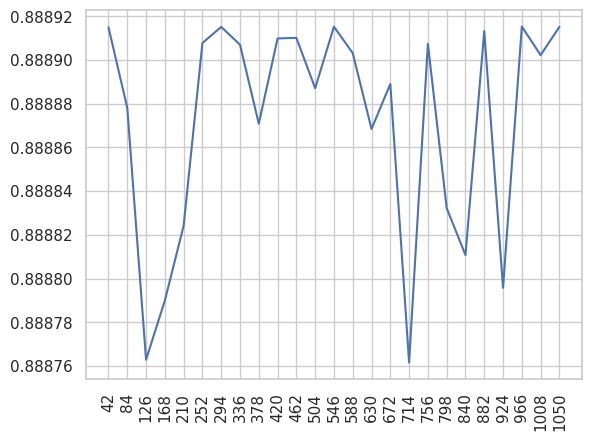

In [ ]:
seeds_ticks = range(len(seeds))
plt.plot(seeds_ticks, loss_history_prime)
plt.xticks(seeds_ticks, seeds, rotation=90)
plt.show()

### Compare trainings

In [ ]:
print_L1_L2(C_import_nn, C_prime_import_nn)

print("\n")
print("R2 C: ", np.mean(loss_history_C))
print("R2 C_prime: ", np.mean(loss_history_prime))

model C
L1 norm
mean: 1.0261369
L2 norm
mean: 0.59244037


model C_prime
L1 norm
mean: 0.5119147
L2 norm
mean: 0.51173365


Ratio between models
L1_C_prime/L1_C
0.49887562


L2_C_prime/L2_C
0.86377245


R2 C:  0.8887543084465739
R2 C_prime:  0.8888723239484135


## Stochastic Decision Tree

### Train using C

In [ ]:
from sklearn.tree import DecisionTreeRegressor

C_import_tree = []
loss_history_C_tree = []

# train the model multiple times with different seeds
for seed in seeds:
  set_reproducibility(seed)

  model_C = DecisionTreeRegressor(splitter="random", random_state=seed)

  model_C.fit(df[['A','B','C']], df['D'])

  loss_history_C_tree.append(model_C.score(df[['A','B','C']], df['D']))
  C_import_tree.append(model_C.feature_importances_)

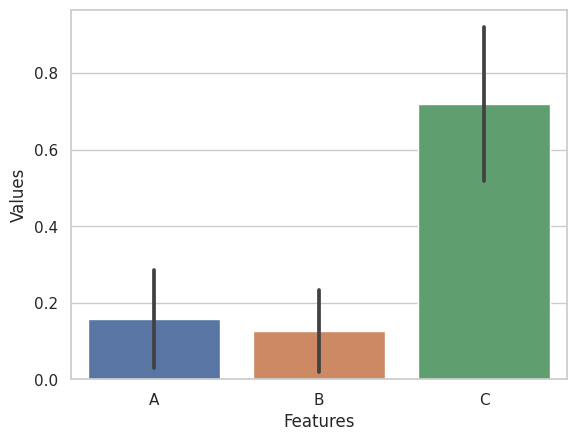

In [ ]:
results = pd.DataFrame(C_import_tree, index=seeds, columns=["A", "B","C"])
plot_coefs(results)

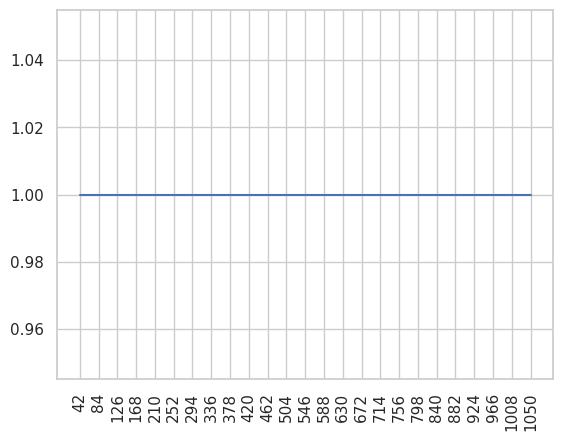

In [ ]:
seeds_ticks = range(len(seeds))
plt.plot(seeds_ticks, loss_history_C_tree)
plt.xticks(seeds_ticks, seeds, rotation=90)
plt.show()

### Train using C_prime

In [ ]:
from sklearn.tree import DecisionTreeRegressor

C_prime_import_tree = []
loss_history_prime_tree = []

# train the model multiple times with different seeds
for seed in seeds:
  set_reproducibility(seed)

  model_C_prime = DecisionTreeRegressor(splitter="random", random_state=seed)

  model_C_prime.fit(df[['A','B','C_prime']], df['D'])

  loss_history_prime_tree.append(model_C_prime.score(df[['A','B','C_prime']], df['D']))
  C_prime_import_tree.append(model_C_prime.feature_importances_)

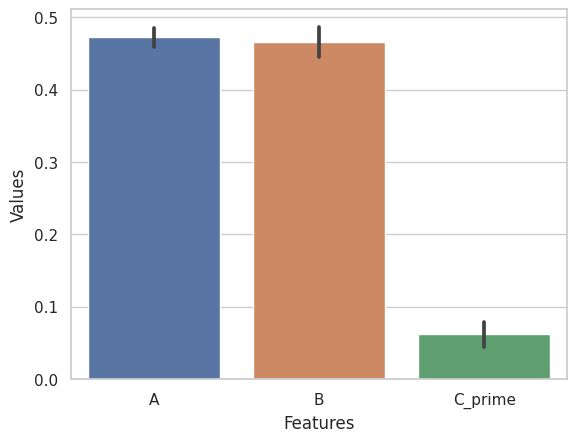

In [ ]:
results = pd.DataFrame(C_prime_import_tree, index=seeds, columns=["A", "B","C_prime"])
plot_coefs(results)

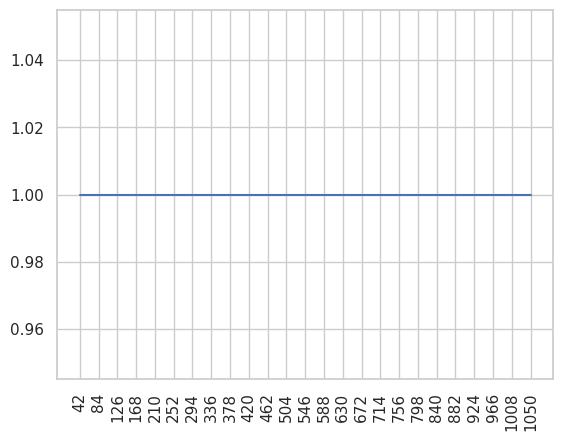

In [ ]:
seeds_ticks = range(len(seeds))
plt.plot(seeds_ticks, loss_history_prime_tree)
plt.xticks(seeds_ticks, seeds, rotation=90)
plt.show()

### Compare trainings

In [ ]:
print_L1_L2(C_import_tree, C_prime_import_tree)

print("\n")
print("R2 C: ", np.mean(loss_history_C_tree))
print("R2 C_prime: ", np.mean(loss_history_prime_tree))

model C
L1 norm
mean: 0.37421617074843455
L2 norm
mean: 0.23398470142649447


model C_prime
L1 norm
mean: 0.03344633293629044
L2 norm
mean: 0.021331479234652315


Ratio between models
L1_C_prime/L1_C
0.08937703806171064


L2_C_prime/L2_C
0.09116612797590756


R2 C:  1.0
R2 C_prime:  1.0


# Graph with noise #2

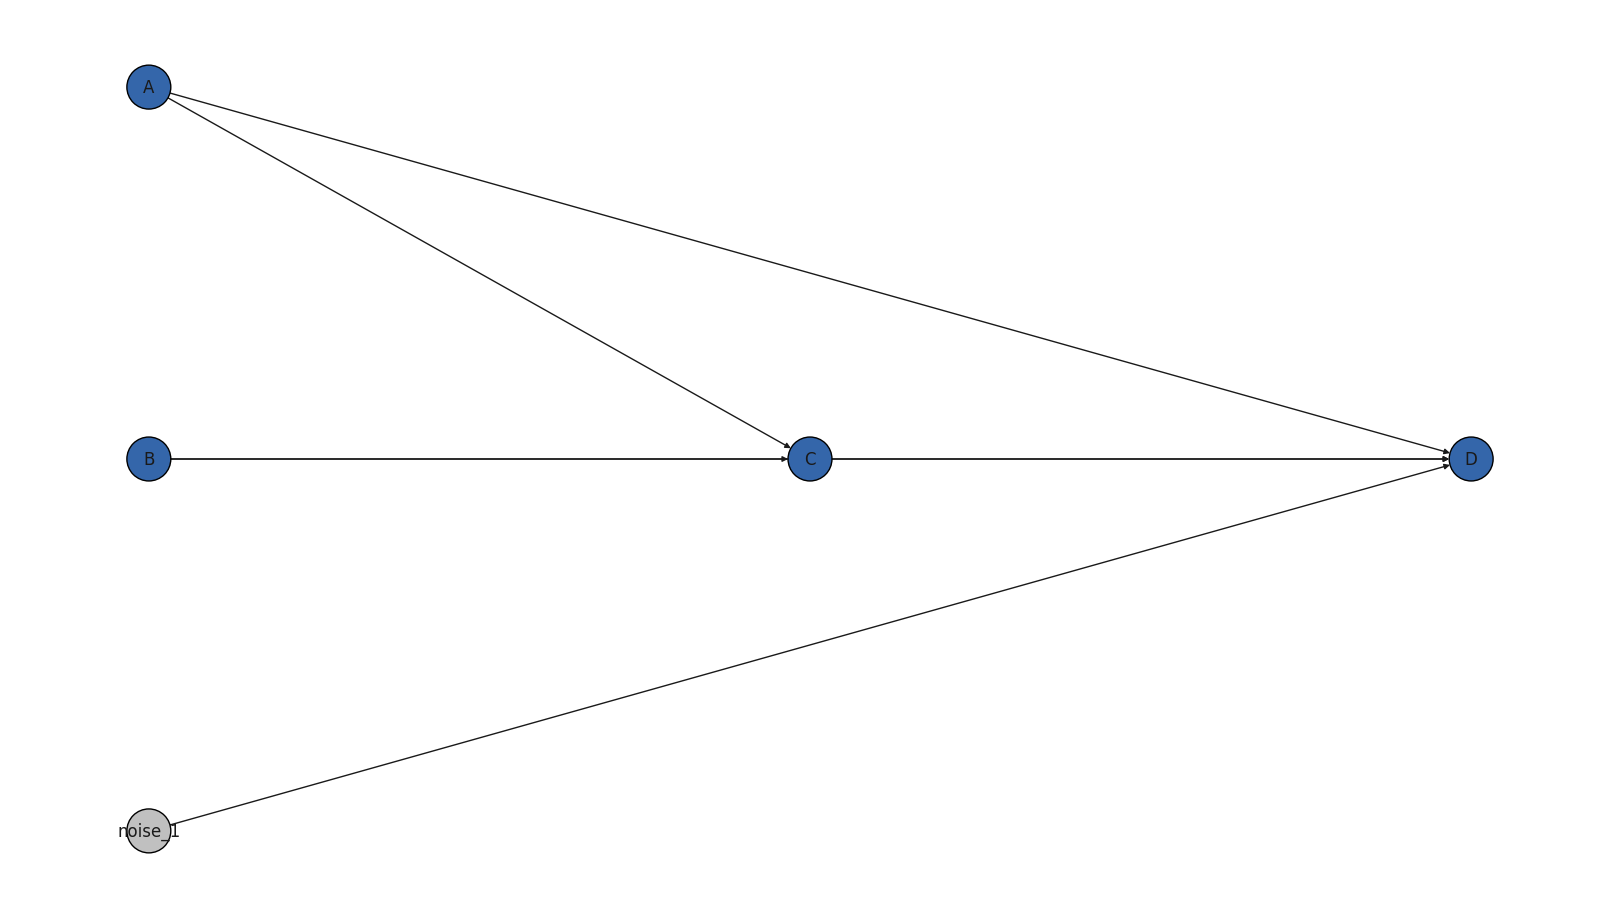

In [ ]:
seed = 42

set_reproducibility(seed)

dg = Generator(seed=seed)

A = dg.normal(mu=0.5, sigma=0.5, name='A')

B = dg.normal(mu=0.5, sigma=0.5, name='B')

C = dg.descendant(A + B, name='C')

D = dg.descendant(A + B - 3 * C + dg.noise(), name='D')

df = dg.generate(hidden=True)
dg.visualize()

## Generate data

In [ ]:
print('\n\nGenerated Dataset')
df = pd.DataFrame(dg.generate(num=num_data))
df.head()



Generated Dataset


,A,B,C,D
0,0.970282,0.357351,1.327633,-3.255176
1,-0.475518,0.914577,0.439059,-1.128936
2,-0.151090,0.532800,0.381710,0.273350
3,0.563920,1.233667,1.797587,-2.863934
4,0.341879,-0.287962,0.053917,-0.235758


## Capture correlation

Capture correlation [A->C, B->C], train the model over A and B to predict C

Then compute C_prime as C-M(A,B)

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def build_C_prime(df):

  model = keras.Sequential([
      keras.layers.Dense(10, input_shape=[2], activation='relu'),
      keras.layers.Dense(1)
      ])

  model.compile(loss='mse', optimizer='adam')
  model.fit(df[['A','B']], df['C'],
      epochs=10,
      batch_size=32,
      verbose=False
      )

  df['C_new'] = model.predict(df[['A','B']])
  df['C_prime'] = df['C'] - df['C_new']

  return df

In [ ]:
df = build_C_prime(df)

df.head()

313/313 [==============================] - 0s 1ms/step


,A,B,C,D,C_new,C_prime
0,0.970282,0.357351,1.327633,-3.255176,1.320470,0.007163
1,-0.475518,0.914577,0.439059,-1.128936,0.381773,0.057286
2,-0.151090,0.532800,0.381710,0.273350,0.396190,-0.014480
3,0.563920,1.233667,1.797587,-2.863934,1.812211,-0.014624
4,0.341879,-0.287962,0.053917,-0.235758,0.053550,0.000367


## Stochastic Linear Regression

### Training C

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.metrics import r2_score

C_import_nn = []
loss_history_C = []

# train the model multiple times with different seeds
for seed in seeds:
  set_reproducibility(seed)

  model_C = Sequential()
  model_C.add(Dense(1, input_dim=3, activation='linear'))

  sgd = SGD()
  model_C.compile(loss='mean_squared_error', optimizer=sgd)

  # fit the model and store the weights
  model_C.fit(df[['A','B','C']], df['D'], epochs=epochs)

  y_pred = model_C.predict(df[['A','B','C']])

  loss_history_C.append(r2_score(df['D'], y_pred))
  C_import_nn.append(model_C.layers[0].get_weights()[0].flatten())

Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 1.3078
Epoch 2/2
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 1.3920
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 1.5740
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 1ms/step - loss: 1.5146
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 1ms/step - loss: 1.4263
Epoch 2/2
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 1.0302
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 1.2089
Epoch 2/2
313/313 [==============================]

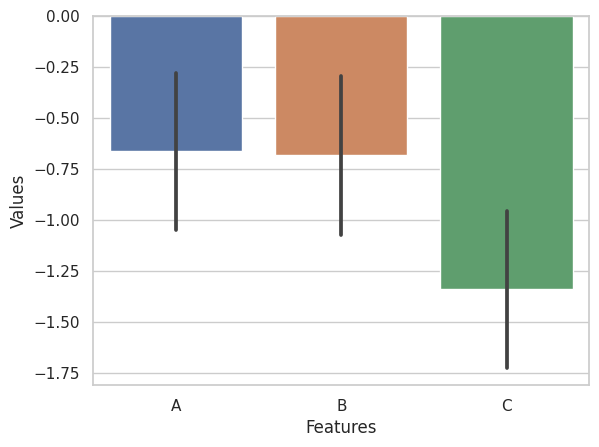

In [ ]:
results = pd.DataFrame(C_import_nn, index=seeds, columns=["A", "B","C"])
plot_coefs(results)

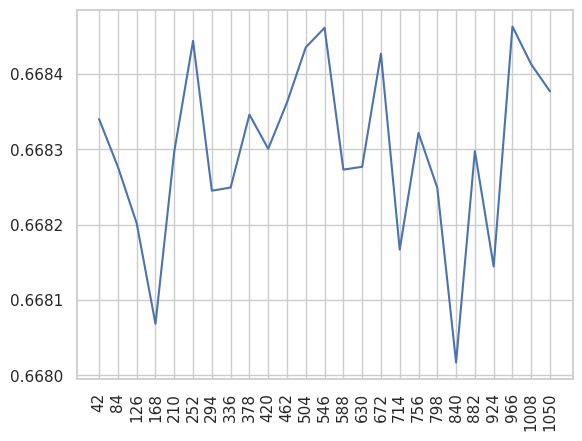

In [ ]:
seeds_ticks = range(len(seeds))
plt.plot(seeds_ticks, loss_history_C)
plt.xticks(seeds_ticks, seeds, rotation=90)
plt.show()

### Training C_prime

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.metrics import r2_score

C_prime_import_nn = []
loss_history_prime = []

# train the model multiple times with different seeds
for seed in seeds:
  set_reproducibility(seed)

  model_C_prime = Sequential()
  model_C_prime.add(Dense(1, input_dim=3, activation='linear'))

  sgd = SGD()
  model_C_prime.compile(loss='mean_squared_error', optimizer=sgd)

  # fit the model and store the weights
  model_C_prime.fit(df[['A','B','C_prime']], df['D'], epochs=epochs)

  y_pred = model_C_prime.predict(df[['A','B','C_prime']])

  loss_history_prime.append(r2_score(df['D'], y_pred))
  C_prime_import_nn.append(model_C_prime.layers[0].get_weights()[0].flatten())

Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 2.0638
Epoch 2/2
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 1.8175
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 1ms/step - loss: 1.7500
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 1.6090
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 1ms/step - loss: 1.6772
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 1.2395
Epoch 2/2
313/313 [==============================] - 0s 1ms/step
Epoch 1/2
313/313 [==============================] - 1s 2ms/step - loss: 1.5481
Epoch 2/2
313/313 [==============================]

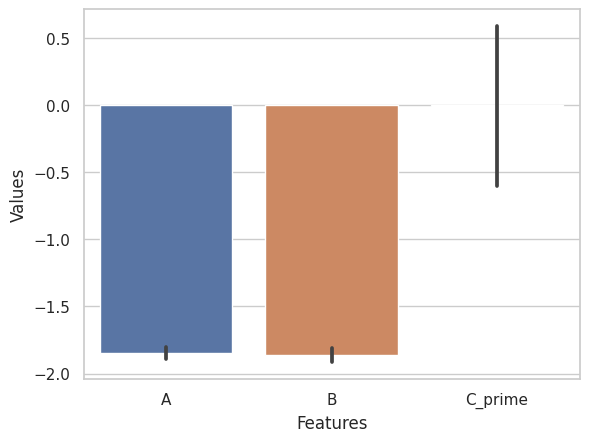

In [ ]:
results = pd.DataFrame(C_prime_import_nn, index=seeds, columns=["A", "B","C_prime"])
plot_coefs(results)

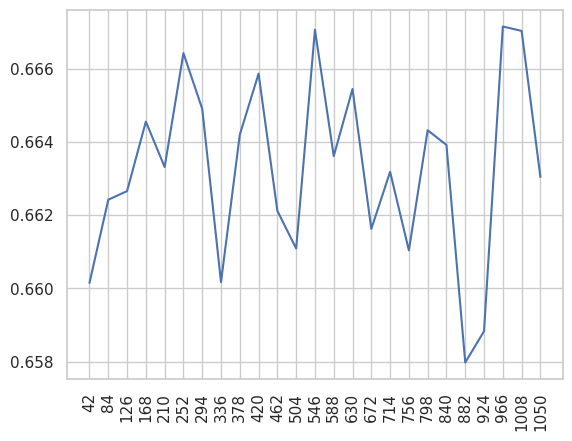

In [ ]:
seeds_ticks = range(len(seeds))
plt.plot(seeds_ticks, loss_history_prime)
plt.xticks(seeds_ticks, seeds, rotation=90)
plt.show()

### Compare trainings

In [ ]:
print_L1_L2(C_import_nn, C_prime_import_nn)

print("\n")
print("R2 C: ", np.mean(loss_history_C))
print("R2 C_prime: ", np.mean(loss_history_prime))

model C
L1 norm
mean: 1.0261371
L2 norm
mean: 0.59357613


model C_prime
L1 norm
mean: 0.58361554
L2 norm
mean: 0.5128237


Ratio between models
L1_C_prime/L1_C
0.5687501


L2_C_prime/L2_C
0.8639561


R2 C:  0.6682982483004021
R2 C_prime:  0.6632813961582664


## Stochastic Decision Tree

### Train using C

In [ ]:
from sklearn.tree import DecisionTreeRegressor

C_import_tree = []
loss_history_C_tree = []

# train the model multiple times with different seeds
for seed in seeds:
  set_reproducibility(seed)

  model_C = DecisionTreeRegressor(splitter="random", random_state=seed)

  model_C.fit(df[['A','B','C']], df['D'])

  loss_history_C_tree.append(model_C.score(df[['A','B','C']], df['D']))
  C_import_tree.append(model_C.feature_importances_)

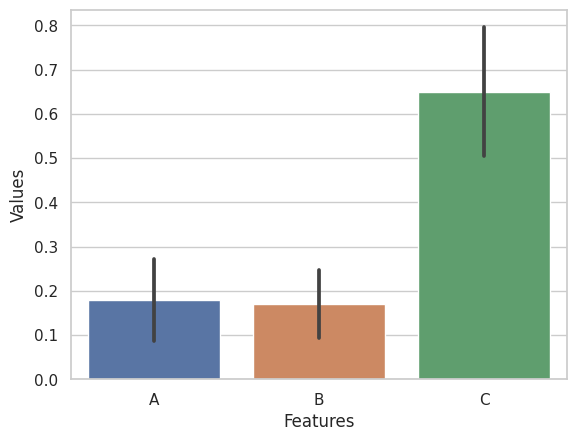

In [ ]:
results = pd.DataFrame(C_import_tree, index=seeds, columns=["A", "B","C"])
plot_coefs(results)

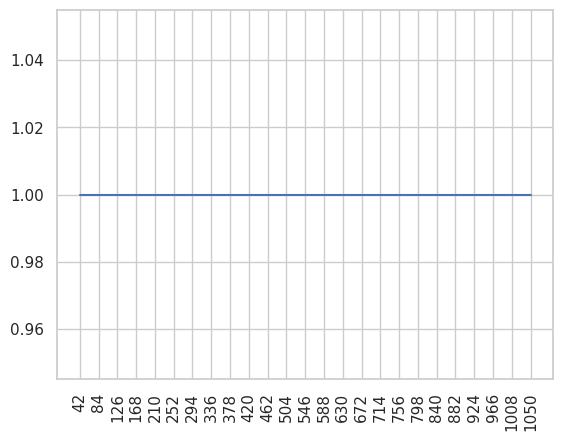

In [ ]:
seeds_ticks = range(len(seeds))
plt.plot(seeds_ticks, loss_history_C_tree)
plt.xticks(seeds_ticks, seeds, rotation=90)
plt.show()

### Train using C_prime

In [ ]:
from sklearn.tree import DecisionTreeRegressor

C_prime_import_tree = []
loss_history_prime_tree = []

# train the model multiple times with different seeds
for seed in seeds:
  set_reproducibility(seed)

  model_C_prime = DecisionTreeRegressor(splitter="random", random_state=seed)

  model_C_prime.fit(df[['A','B','C_prime']], df['D'])

  loss_history_prime_tree.append(model_C_prime.score(df[['A','B','C_prime']], df['D']))
  C_prime_import_tree.append(model_C_prime.feature_importances_)

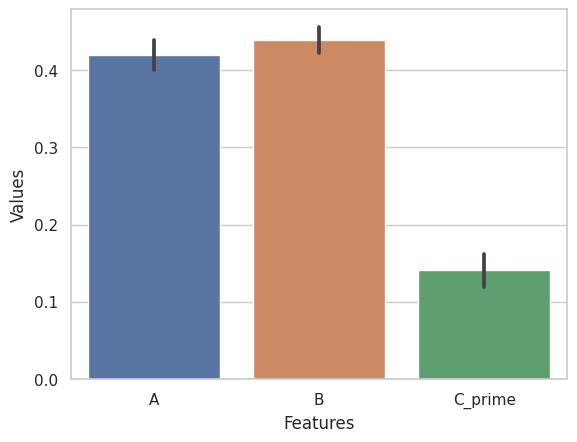

In [ ]:
results = pd.DataFrame(C_prime_import_tree, index=seeds, columns=["A", "B","C_prime"])
plot_coefs(results)

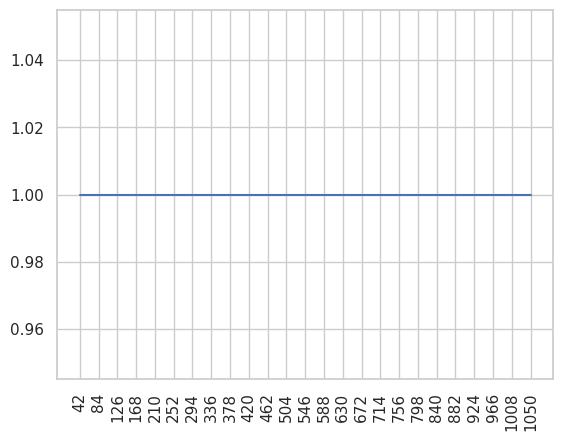

In [ ]:
seeds_ticks = range(len(seeds))
plt.plot(seeds_ticks, loss_history_prime_tree)
plt.xticks(seeds_ticks, seeds, rotation=90)
plt.show()

### Compare trainings

In [ ]:
print_L1_L2(C_import_tree, C_prime_import_tree)

print("\n")
print("R2 C: ", np.mean(loss_history_C_tree))
print("R2 C_prime: ", np.mean(loss_history_prime_tree))

model C
L1 norm
mean: 0.2680733598366505
L2 norm
mean: 0.16755374404756157


model C_prime
L1 norm
mean: 0.043451467564309364
L2 norm
mean: 0.02773916024682259


Ratio between models
L1_C_prime/L1_C
0.1620879731980319


L2_C_prime/L2_C
0.16555380725451643


R2 C:  1.0
R2 C_prime:  1.0


#Project extension

### Functions

In [ ]:
fixed_seed = 69

In [ ]:
def compute_C_prime(df):

  model = keras.Sequential([
      keras.layers.Dense(10, input_shape=[2], activation='relu'),
      keras.layers.Dense(1)
      ])

  model.compile(loss='mse', optimizer='adam')
  model.fit(df[['A','B']], df['C'],
      epochs=10,
      batch_size=32,
      verbose=0
      )

  df['C_new'] = model.predict(df[['A','B']], verbose=0)
  df['C_prime'] = df['C'] - df['C_new']

  return df

In [ ]:
def build_SLR():
  model = Sequential()
  model.add(Dense(1, input_dim=3, activation='linear'))
  sgd = SGD()
  model.compile(loss='mean_squared_error', optimizer=sgd)
  return model

def build_SDT(seed):
  model = DecisionTreeRegressor(splitter="random", random_state=seed)
  return model

In [ ]:
def fit(model, dataset, epochs=None, C_prime=False):
    if C_prime:
        feature_columns = ['A', 'B', 'C_prime']
    else:
        feature_columns = ['A', 'B', 'C']

    if isinstance(model, DecisionTreeRegressor):
        model.fit(dataset[feature_columns], dataset['D'])
        y_pred = model.predict(dataset[feature_columns])
        score = r2_score(dataset['D'], y_pred)
        weights = model.feature_importances_
    else:
        if epochs is None:
            raise ValueError("Epochs parameter must be provided for Sequential models.")
        model.fit(dataset[feature_columns], dataset['D'], epochs=epochs, verbose=0)
        y_pred = model.predict(dataset[feature_columns], verbose=0)
        score = r2_score(dataset['D'], y_pred)
        weights = model.layers[0].get_weights()[0].flatten()

    return weights, score

In [ ]:
def run_experiment(generator, epochs, fixed_seed, seeds, C_prime=False):

  slr_weights = []
  slr_scores_history = []
  sdt_weights = []
  sdt_scores_history = []

  for seed in tqdm(seeds, desc="Running experiment", unit="seed"):

    # Build dataset
    set_reproducibility(seed)
    df = pd.DataFrame(generator(seed, num_data))
    if C_prime:
      df = compute_C_prime(df)

    # set fixed seed, build models and train them
    set_reproducibility(fixed_seed)
    slr = build_SLR()
    sdt = build_SDT(fixed_seed)

    weights, scores = fit(slr, df, epochs=epochs, C_prime=C_prime)
    slr_weights.append(weights)
    slr_scores_history.append(scores)

    weights, scores = fit(sdt, df, C_prime=C_prime)
    sdt_weights.append(weights)
    sdt_scores_history.append(scores)

  return slr_weights, slr_scores_history, sdt_weights, sdt_scores_history

In [ ]:
def print_bold(text):
    bold_text = f"\033[1m{text}\033[0m"
    print(bold_text)

## Graph

In [ ]:
def generate_data(seed, num_data):

  dg = Generator(seed=seed)

  A = dg.normal(mu=0, sigma=1, name='A')

  B = dg.normal(mu=0, sigma=1, name='B')

  C = dg.descendant(A + B, name='C')

  D = dg.descendant(A + B - 3 * C, name='D')

  dg.generate(hidden=True)

  return dg.generate(num=num_data)


### Train with C

In [ ]:
slr_weights, slr_scores_history, sdt_weights, sdt_scores_history = run_experiment(generate_data, epochs, fixed_seed, seeds)

Running experiment: 100%|██████████| 25/25 [00:58<00:00,  2.35s/seed]


Stochastic Linear Regressor weights variance with C


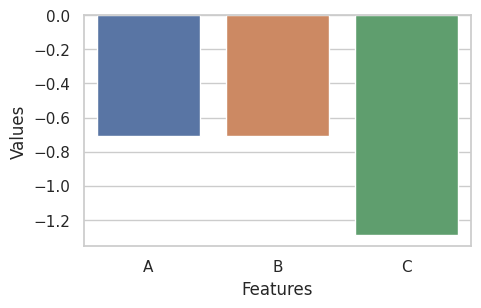



Stochastic Decision Tree weights variance with C


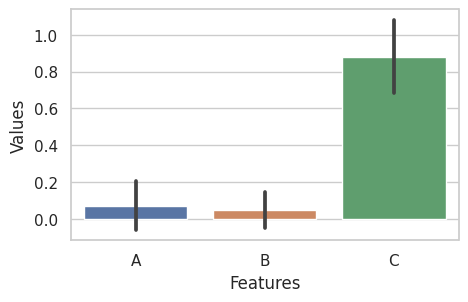

In [ ]:
print_bold("Stochastic Linear Regressor weights variance with C")
plot_coefs( pd.DataFrame(slr_weights, columns=["A", "B","C"]) )
print("\n")
print_bold("Stochastic Decision Tree weights variance with C")
plot_coefs( pd.DataFrame(sdt_weights, columns=["A", "B","C"]) )

### Train with C_prime

In [ ]:
slr_weights_C_prime, slr_score_history_C_prime, sdt_weights_C_prime, sdt_score_history_C_prime = run_experiment(generate_data, epochs, fixed_seed, seeds, C_prime=True)

Running experiment: 100%|██████████| 25/25 [04:11<00:00, 10.07s/seed]


Stochastic Linear Regressor weights variance with C_prime


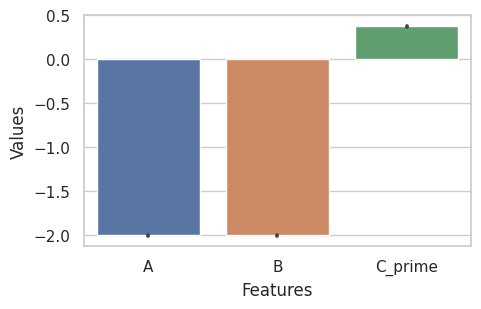



Stochastic Decision Tree weights variance with C_prime


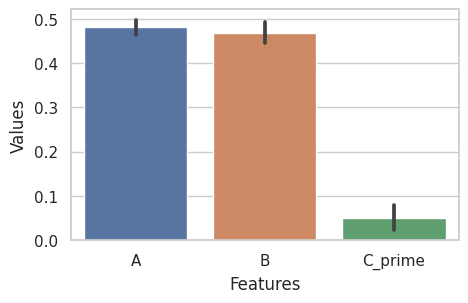

In [ ]:
print_bold("Stochastic Linear Regressor weights variance with C_prime")
plot_coefs( pd.DataFrame(slr_weights_C_prime, columns=["A", "B","C_prime"]) )
print("\n")
print_bold("Stochastic Decision Tree weights variance with C_prime")
plot_coefs( pd.DataFrame(sdt_weights_C_prime, columns=["A", "B","C_prime"]) )

In [ ]:
print_L1_L2(slr_weights, slr_weights_C_prime)
print_L1_L2(sdt_weights, sdt_weights_C_prime)

model C
L1 norm
mean: 1.3756752e-06
L2 norm
mean: 8.739591e-07


model C_prime
L1 norm
mean: 0.008916402
L2 norm
mean: 0.0080644665


model C
L1 norm
mean: 0.3415288087950451
L2 norm
mean: 0.21640454585936125


model C_prime
L1 norm
mean: 0.0566330561201484
L2 norm
mean: 0.03628904706719195




## Graph with noise

In [ ]:
def generate_data_w_noise(seed, num_data):

  dg = Generator(seed=seed)

  A = dg.normal(mu=0, sigma=1, name='A')

  B = dg.normal(mu=0, sigma=1, name='B')

  C = dg.descendant(A + B, name='C')

  D = dg.descendant(A + B - 3 * C, noise=0.2, name='D')

  dg.generate(hidden=True)

  return dg.generate(num=num_data)

### Train with C

In [ ]:
slr_weights, slr_scores_history, sdt_weights, sdt_scores_history = run_experiment(generate_data_w_noise, epochs, fixed_seed, seeds)

Running experiment: 100%|██████████| 25/25 [01:00<00:00,  2.43s/seed]


Stochastic Linear Regressor weights variance with C


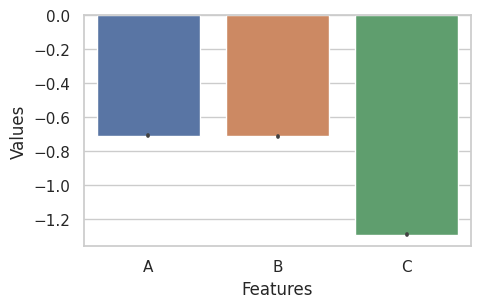



Stochastic Decision Tree weights variance with C


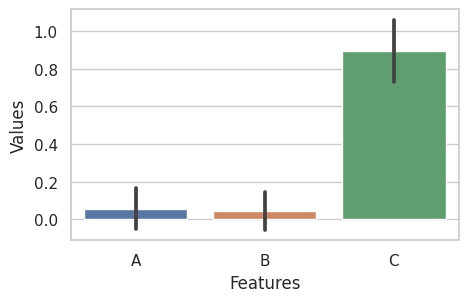

In [ ]:
print_bold("Stochastic Linear Regressor weights variance with C")
plot_coefs( pd.DataFrame(slr_weights, columns=["A", "B","C"]) )
print("\n")
print_bold("Stochastic Decision Tree weights variance with C")
plot_coefs( pd.DataFrame(sdt_weights, columns=["A", "B","C"]) )

### Train with C_prime

In [ ]:
slr_weights_C_prime, slr_score_history_C_prime, sdt_weights_C_prime, sdt_score_history_C_prime = run_experiment(generate_data_w_noise, epochs, fixed_seed, seeds, C_prime=True)

Running experiment: 100%|██████████| 25/25 [04:25<00:00, 10.63s/seed]


Stochastic Linear Regressor weights variance with C_prime


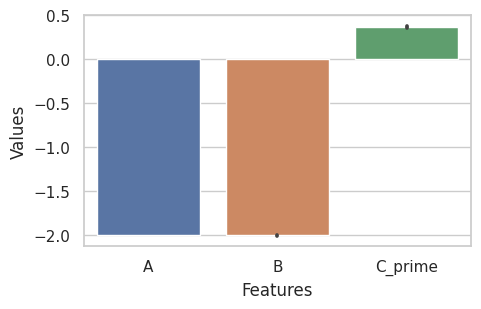



Stochastic Decision Tree weights variance with C_prime


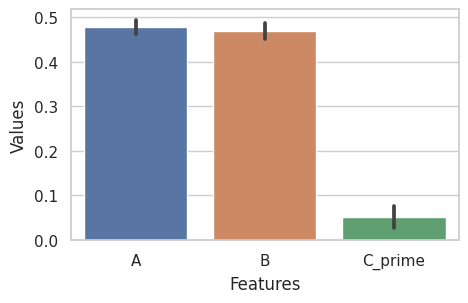

In [ ]:
print_bold("Stochastic Linear Regressor weights variance with C_prime")
plot_coefs( pd.DataFrame(slr_weights_C_prime, columns=["A", "B","C_prime"]) )
print("\n")
print_bold("Stochastic Decision Tree weights variance with C_prime")
plot_coefs( pd.DataFrame(sdt_weights_C_prime, columns=["A", "B","C_prime"]) )

In [ ]:
print_L1_L2(slr_weights, slr_weights_C_prime)
print_L1_L2(sdt_weights, sdt_weights_C_prime)

model C
L1 norm
mean: 0.006394086
L2 norm
mean: 0.0041389447


model C_prime
L1 norm
mean: 0.013501817
L2 norm
mean: 0.009902198


model C
L1 norm
mean: 0.29400115347413786
L2 norm
mean: 0.189336998233465


model C_prime
L1 norm
mean: 0.0484468945260538
L2 norm
mean: 0.030574335494131993


